In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
import seaborn as sns
import matplotlib.pyplot as plt

from doubleml.datasets import make_plr_CCDDHNR2018

from sklearn.linear_model import Lasso, LassoCV
from sklearn.base import clone

from scipy import stats
from tqdm import tqdm

from utils import make_data_list, make_BCH2014_data_list, simulate_lasso_plr, plot_lasso_score,\
                  cover_true

from scipy.linalg import toeplitz

import itertools

np.random.seed(1312)

# 1. Data and Model Preparation

## 1.1 DGP based on CCDDHNR2018

In [2]:
n_rep = 300
n_obs = 500
n_vars = 20
alpha = 0.5
test_train_ratio = 0.1

data = make_data_list(n_rep=n_rep, n_obs=n_obs, n_vars=n_vars, model_type='plr', alpha=alpha)

lasso_alpha_hyperparams_ml_l = [0.001, 0.01, 0.1, 1]
lasso_alpha_hyperparams_ml_m = [0.001, 0.01, 0.1, 1]
n_folds = 5

## 1.2 DGP based on BCH2014

In [4]:
n_rep_BCH14 = 300
theta_BCH14 = 0.5 
n_obs_BCH14 = 100
dim_x_BCH14 = 200 
rho_BCH14 = 0.5
R2_d_BCH14 = 0.5 
R2_y_BCH14 = 0.5 
design_BCH14 = '1a'

random_seed_BCH14 = 1312

data_BCH14 = make_BCH2014_data_list(n_rep=n_rep_BCH14, theta=theta_BCH14, n_obs=n_obs_BCH14, dim_x=dim_x_BCH14,
                                    rho=rho_BCH14, R2_d=R2_d_BCH14, R2_y=R2_y_BCH14, design=design_BCH14, random_seed=random_seed_BCH14)

# 2. Simulation and Hyperparameter Variation

## 2.1 DGB 1: CCDDHNR2018

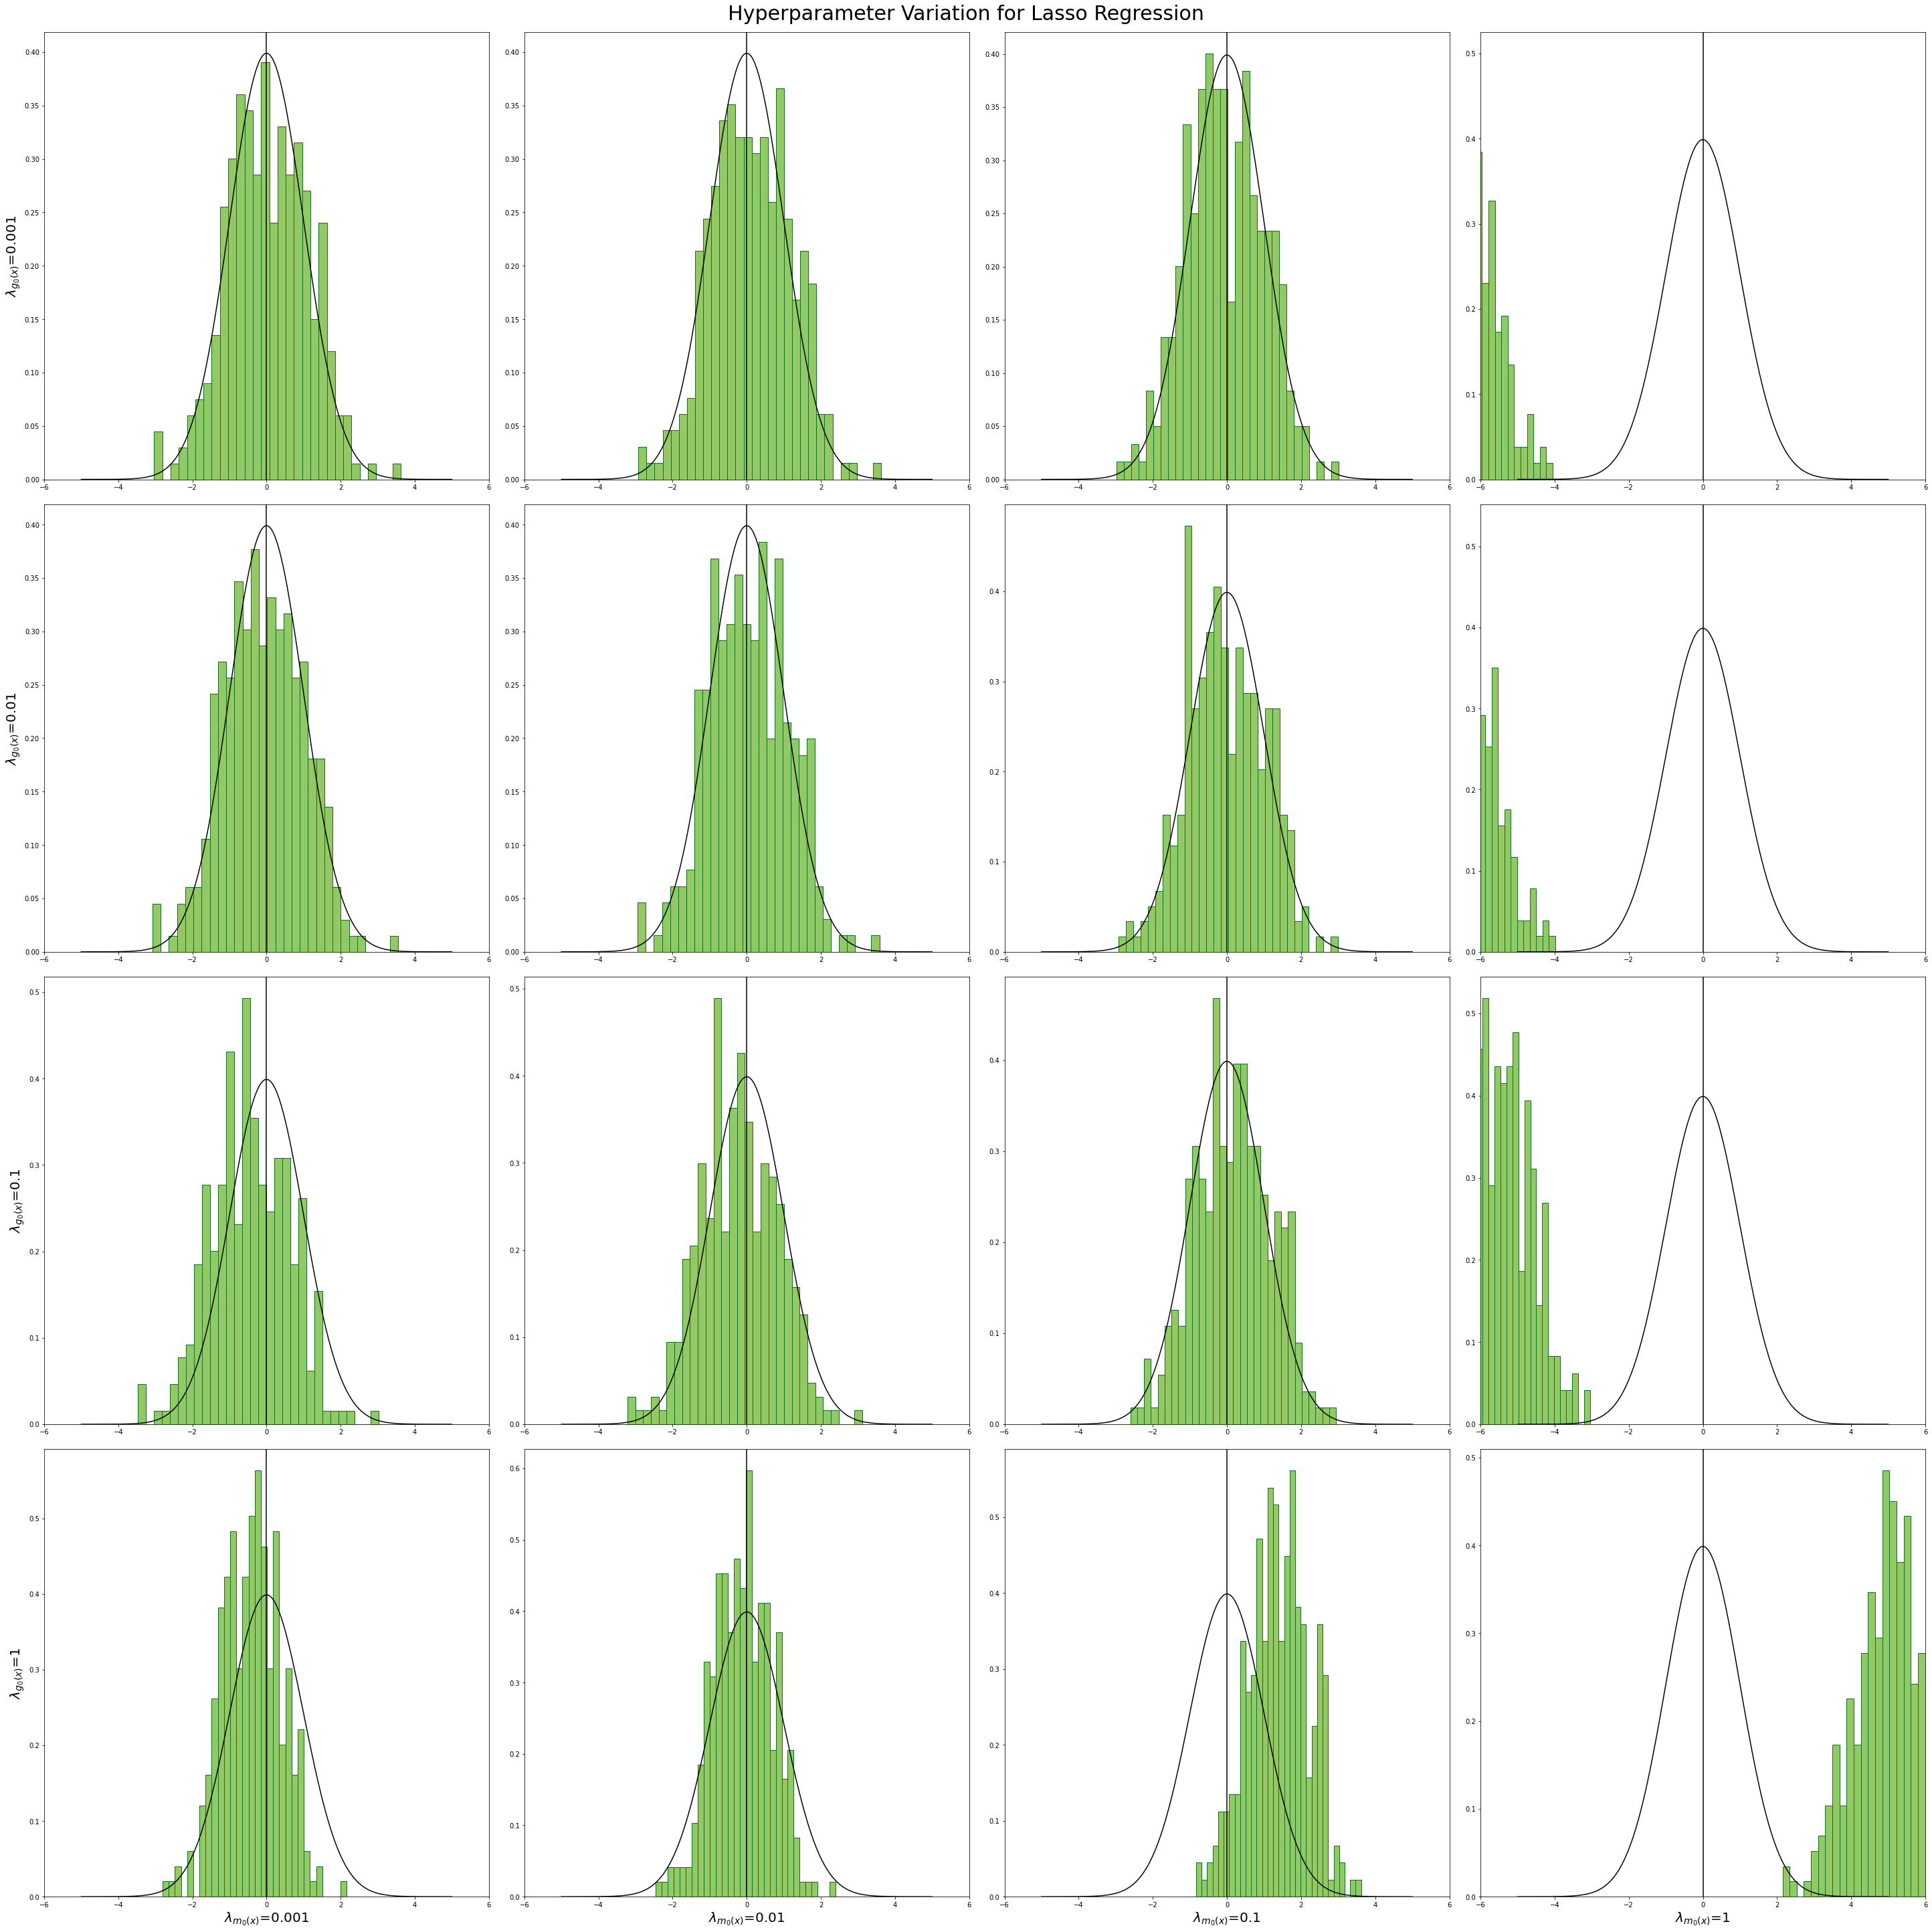

In [4]:
face_colors = sns.color_palette('summer_r')
edge_colors = sns.color_palette('dark')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

mse_scores = []

fig, axs = plt.subplots(len(lasso_alpha_hyperparams_ml_l), len(lasso_alpha_hyperparams_ml_m), 
                        figsize=(10*len(lasso_alpha_hyperparams_ml_l), 10*len(lasso_alpha_hyperparams_ml_m)), 
                        constrained_layout=True)

fig.suptitle("Hyperparameter Variation for Lasso Regression", fontsize=30)

for i_ml_m in lasso_alpha_hyperparams_ml_m:
    for i_ml_l in lasso_alpha_hyperparams_ml_l:

        i_m = lasso_alpha_hyperparams_ml_m.index(i_ml_m)
        i_l = lasso_alpha_hyperparams_ml_l.index(i_ml_l)

        ml_l = Lasso(alpha=i_ml_l)
        ml_m = Lasso(alpha=i_ml_m)
        
        theta_scores, se_scores, plr_objects, in_sample_mses, \
        out_of_samples_mses, _ = simulate_lasso_plr(ml_l=ml_l, ml_m=ml_m, 
                                                    n_folds=n_folds, data=data,
                                                    train_test_split=test_train_ratio, 
                                                    score='partialling out')
        
        mse_entry = {
            "Hyperparameter_m": i_ml_m,
            "Hyperparameter_l": i_ml_l,
            "In_Sample_MSEs": in_sample_mses,
            "Out_Of_Sample_MSEs": out_of_samples_mses,
            "Train_Test_Split": test_train_ratio
        }

        mse_scores.append(mse_entry)

        axs[i_l, i_m].hist((theta_scores - alpha)/se_scores,
                            color=face_colors[2], edgecolor = edge_colors[2],
                            density=True, bins=30, label='Double ML Lasso')
        axs[i_l, i_m].axvline(0., color='k')
        axs[i_l, i_m].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
        #axs[i_l, i_m].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        axs[len(lasso_alpha_hyperparams_ml_l)-1, i_m].set_xlabel('$\\lambda_{m_{0}(x)}$=' + f'{i_ml_m}', fontsize=20)
        axs[i_l, 0].set_ylabel('$\\lambda_{g_{0}(x)}$=' + f'{i_ml_l}', fontsize=20)
        axs[i_l, i_m].set_xlim([-6., 6.])

plt.savefig("plots/lasso_hyperparameter_variation_CCDDHNR2018.png", facecolor="white")

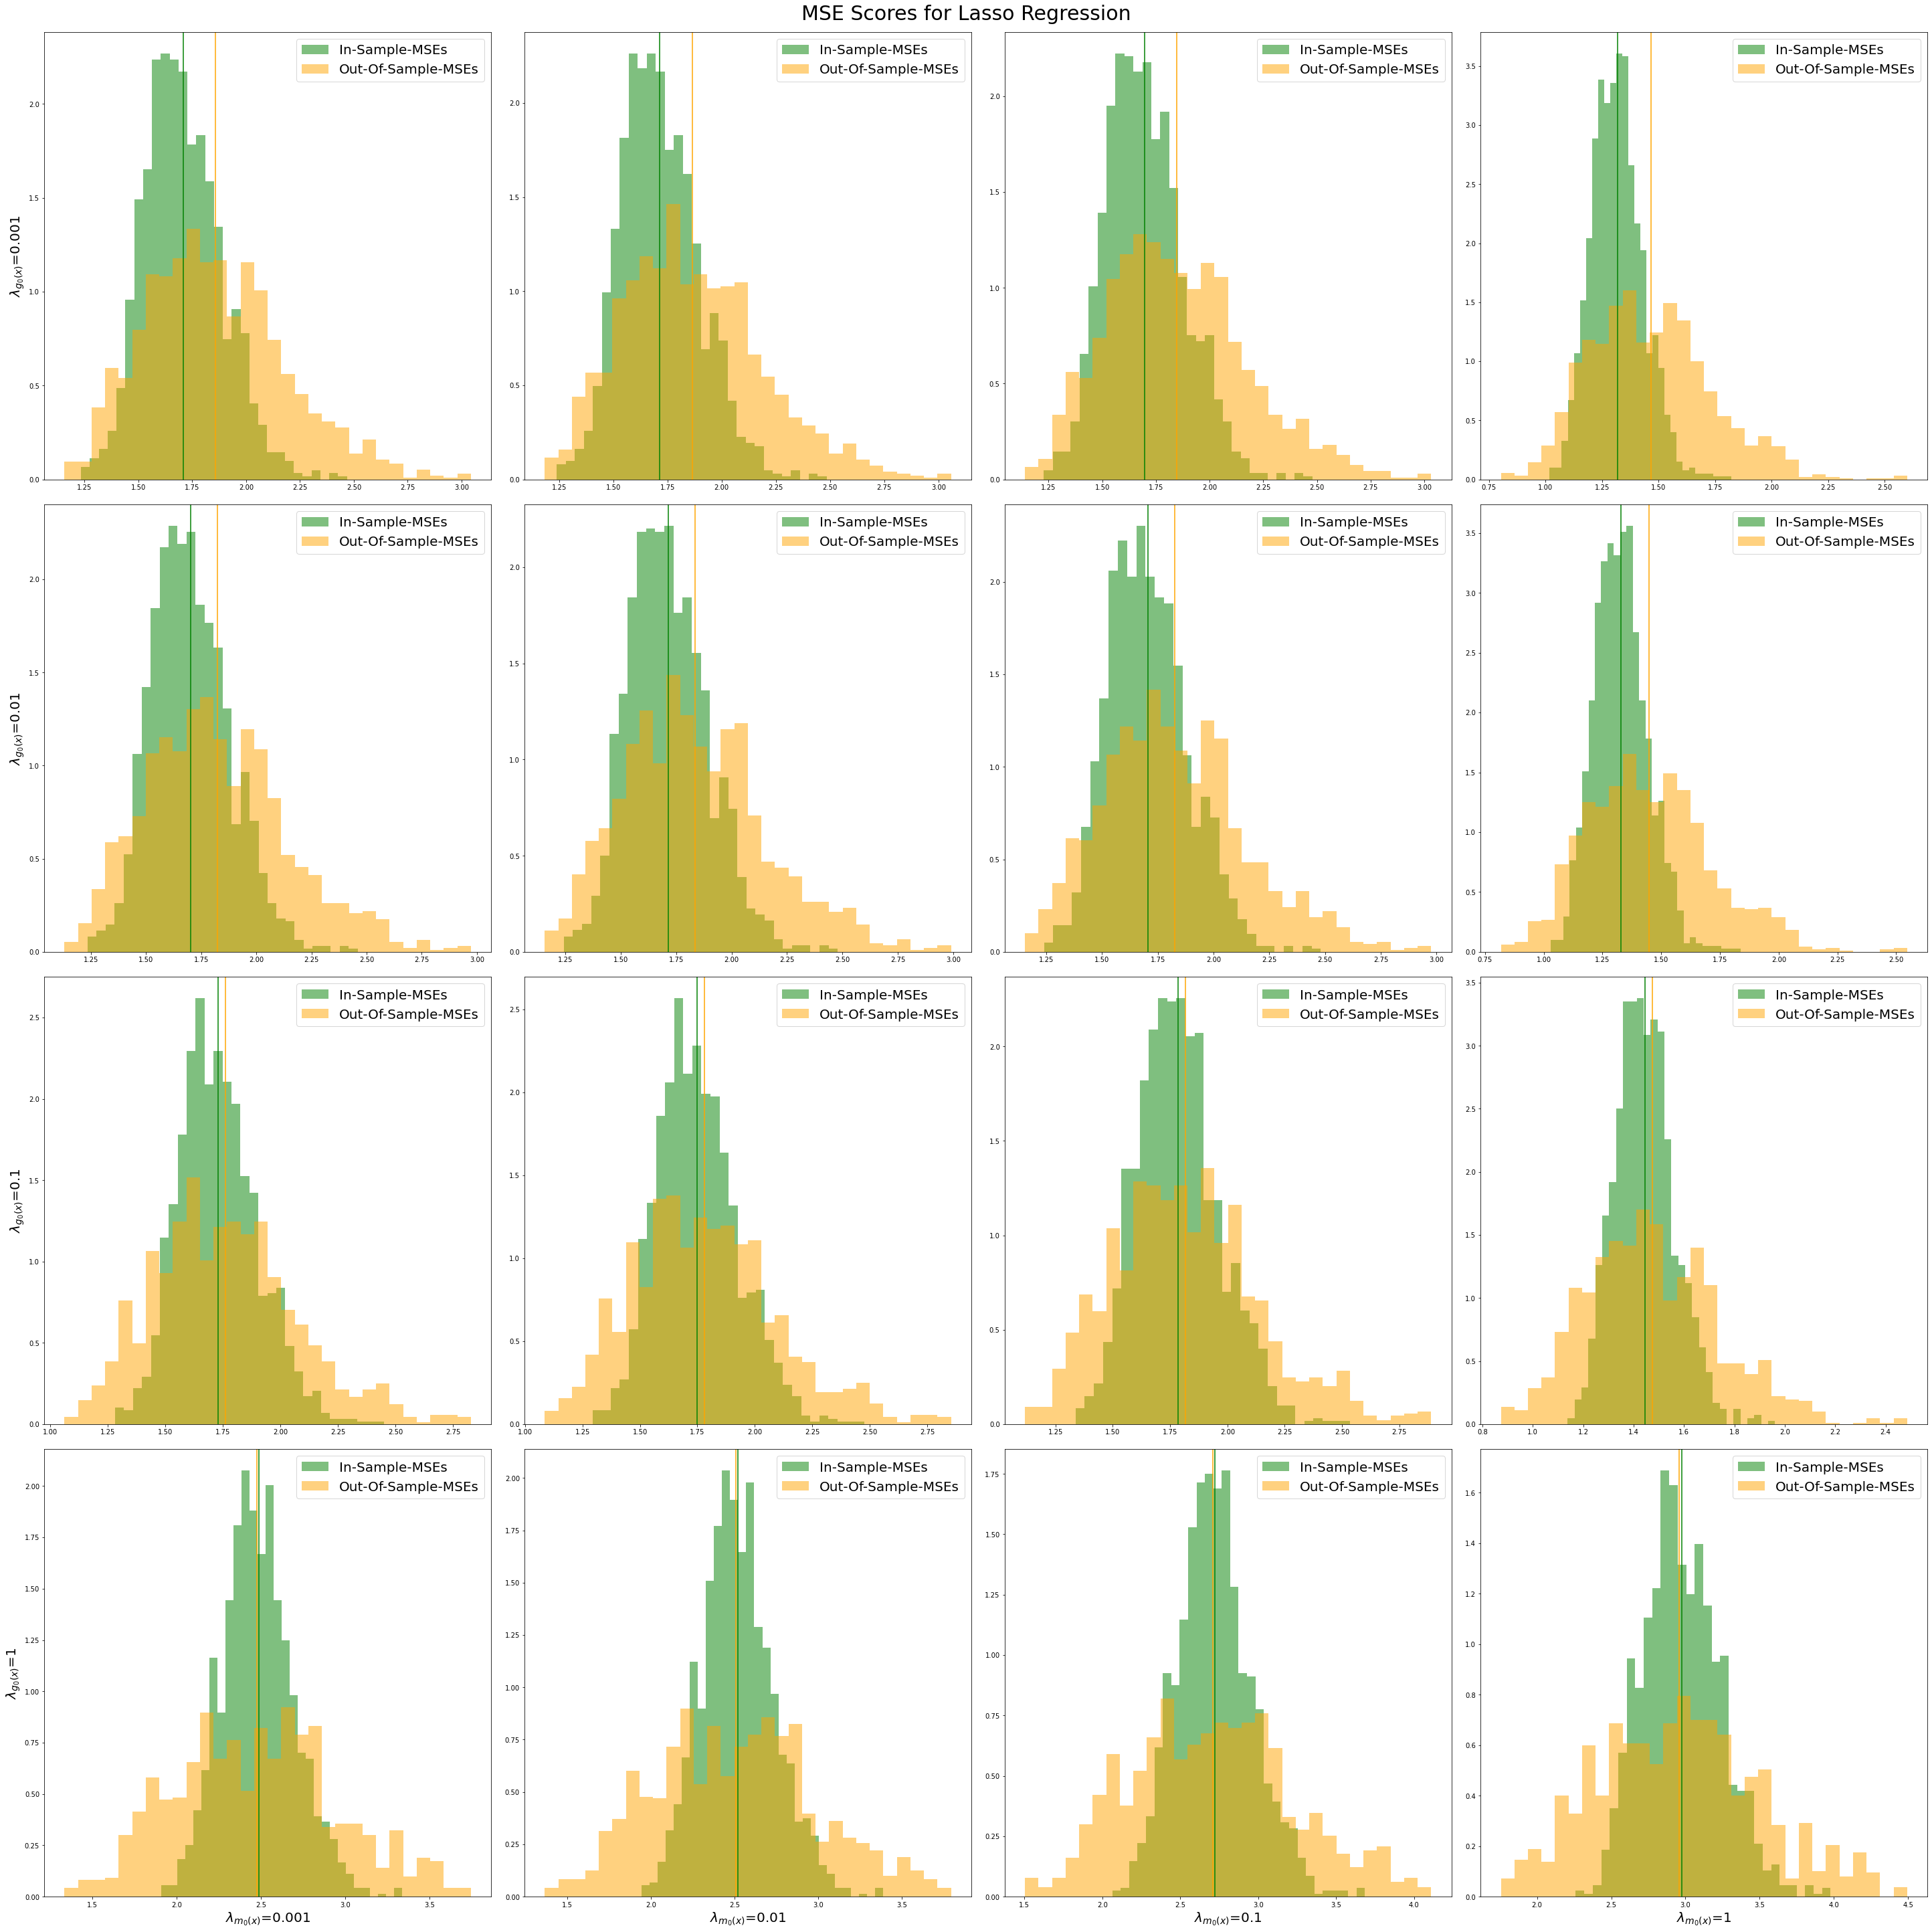

In [5]:
fig, axs = plt.subplots(len(lasso_alpha_hyperparams_ml_l), len(lasso_alpha_hyperparams_ml_m), 
                        figsize=(10*len(lasso_alpha_hyperparams_ml_l), 10*len(lasso_alpha_hyperparams_ml_m)), 
                        constrained_layout=True)

fig.suptitle("MSE Scores for Lasso Regression", fontsize=30)

for i_ml_m in lasso_alpha_hyperparams_ml_m:
    for i_ml_l in lasso_alpha_hyperparams_ml_l:

        dict_entry = next(sim for sim in mse_scores if sim['Hyperparameter_m'] == i_ml_m and sim['Hyperparameter_l'] == i_ml_l)

        i_in_sample_mses = dict_entry['In_Sample_MSEs']
        i_out_sample_mses = dict_entry['Out_Of_Sample_MSEs']

        i_m = lasso_alpha_hyperparams_ml_m.index(i_ml_m)
        i_l = lasso_alpha_hyperparams_ml_l.index(i_ml_l)

        axs[i_l, i_m].hist(i_in_sample_mses, color='green',
                            density=True, bins=30, alpha=0.5, label='In-Sample-MSEs')
        axs[i_l, i_m].axvline(np.mean(i_in_sample_mses), color='green')

        axs[i_l, i_m].hist(i_out_sample_mses, color='orange',
                            density=True, bins=30, alpha=0.5, label='Out-Of-Sample-MSEs')
        axs[i_l, i_m].axvline(np.mean(i_out_sample_mses), color='orange')

        axs[i_l, i_m].legend(loc='upper right', prop={'size': 20})
        axs[len(lasso_alpha_hyperparams_ml_l)-1, i_m].set_xlabel('$\\lambda_{m_{0}(x)}$=' + f'{i_ml_m}', fontsize=20)
        axs[i_l, 0].set_ylabel('$\\lambda_{g_{0}(x)}$=' + f'{i_ml_l}', fontsize=20)

        

## 2.2 DGP 2: BCH2014

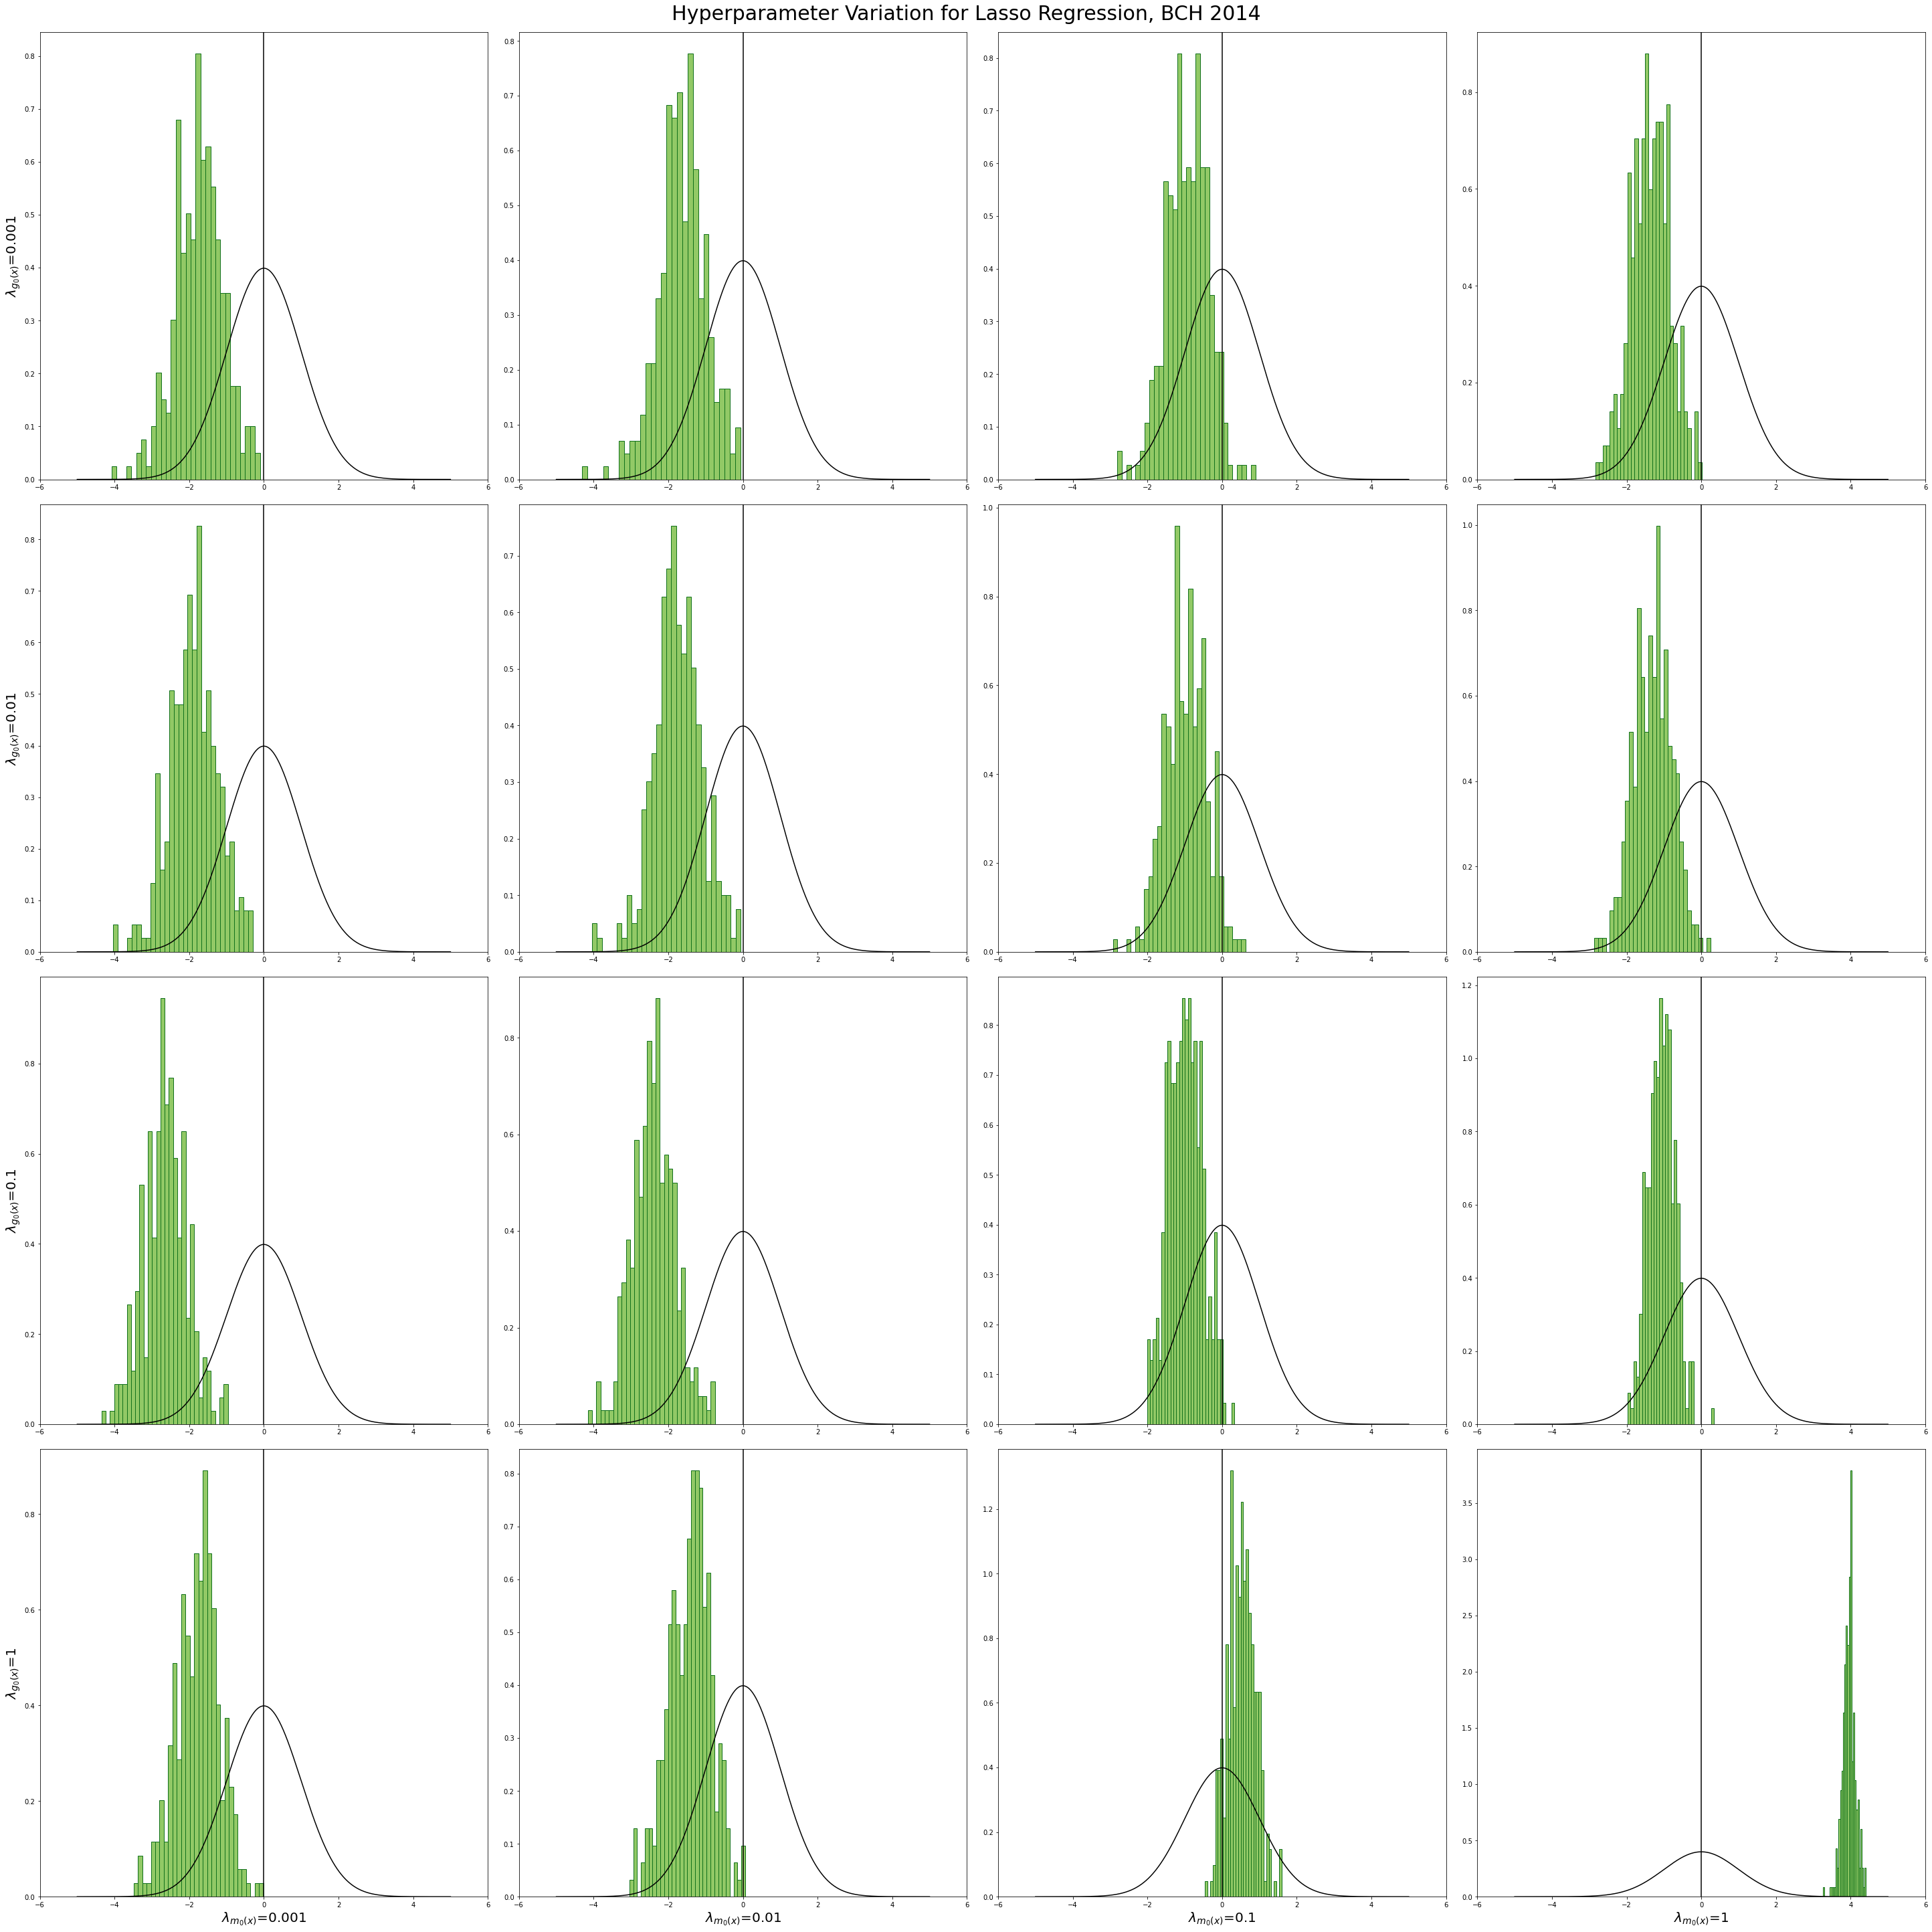

In [12]:
face_colors = sns.color_palette('summer_r')
edge_colors = sns.color_palette('dark')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

mse_scores = []

fig, axs = plt.subplots(len(lasso_alpha_hyperparams_ml_l), len(lasso_alpha_hyperparams_ml_m), 
                        figsize=(10*len(lasso_alpha_hyperparams_ml_l), 10*len(lasso_alpha_hyperparams_ml_m)), 
                        constrained_layout=True)

fig.suptitle("Hyperparameter Variation for Lasso Regression, BCH 2014", fontsize=30)

for i_ml_m in lasso_alpha_hyperparams_ml_m:
    for i_ml_l in lasso_alpha_hyperparams_ml_l:

        i_m = lasso_alpha_hyperparams_ml_m.index(i_ml_m)
        i_l = lasso_alpha_hyperparams_ml_l.index(i_ml_l)

        ml_l = Lasso(alpha=i_ml_l)
        ml_m = Lasso(alpha=i_ml_m)
        
        theta_scores, se_scores, plr_objects, in_sample_mses, \
        out_of_samples_mses, _ = simulate_lasso_plr(ml_l=ml_l, ml_m=ml_m, 
                                                    n_folds=n_folds, data=data_BCH14,
                                                    train_test_split=test_train_ratio, 
                                                    score='partialling out')
        
        mse_entry = {
            "Hyperparameter_m": i_ml_m,
            "Hyperparameter_l": i_ml_l,
            "In_Sample_MSEs": in_sample_mses,
            "Out_Of_Sample_MSEs": out_of_samples_mses,
            "Train_Test_Split": test_train_ratio
        }

        mse_scores.append(mse_entry)

        axs[i_l, i_m].hist((theta_scores - theta_BCH14)/se_scores,
                            color=face_colors[2], edgecolor = edge_colors[2],
                            density=True, bins=30, label='Double ML Lasso')
        axs[i_l, i_m].axvline(0., color='k')
        axs[i_l, i_m].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
        #axs[i_l, i_m].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        axs[len(lasso_alpha_hyperparams_ml_l)-1, i_m].set_xlabel('$\\lambda_{m_{0}(x)}$=' + f'{i_ml_m}', fontsize=20)
        axs[i_l, 0].set_ylabel('$\\lambda_{g_{0}(x)}$=' + f'{i_ml_l}', fontsize=20)
        axs[i_l, i_m].set_xlim([-6., 6.])

plt.savefig("plots/lasso_hyperparameter_variation_BCH2014.png", facecolor="white")

# 3. Lasso Regression with Cross-Validation

## 2.1 DGB 1: CCDDHNR2018

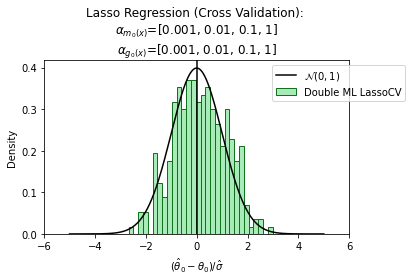

In [7]:
ml_l_cv = LassoCV(alphas=lasso_alpha_hyperparams_ml_l)
ml_m_cv = LassoCV(alphas=lasso_alpha_hyperparams_ml_m)

cv_thetas, cv_se, cv_plr_objects, \
cv_in_samples_mses, cv_out_of_samples_mses, \
cv_alphas = simulate_lasso_plr(ml_l=ml_l_cv, ml_m=ml_m_cv, n_folds=n_folds,
                                train_test_split=test_train_ratio, 
                                data=data, score='partialling out')
plot_lasso_score(ml_l=ml_l_cv, ml_m=ml_m_cv, theta_scores=cv_thetas, se_scores=cv_se, alpha=alpha)

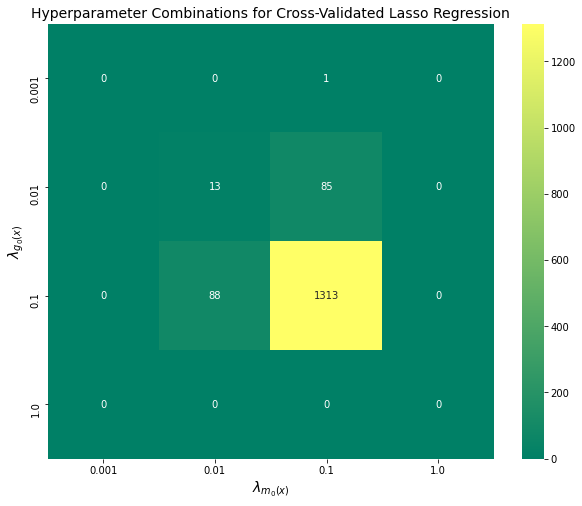

In [8]:
every_hyperparameter_combination = list(itertools.product(lasso_alpha_hyperparams_ml_l,
                                                        lasso_alpha_hyperparams_ml_m))

lasso_alphas_counts = {}

for comb in every_hyperparameter_combination:
    lasso_alphas_counts[comb] = 0

for occ in cv_alphas:
    lasso_alphas_counts[occ] += 1

counts_list = [(k[0], k[1], v) for k, v in lasso_alphas_counts.items()]
lasso_alphas_df = pd.DataFrame(counts_list, columns=['ml_l_alphas', 'ml_m_alphas', 'count'])
pivot_table = lasso_alphas_df.pivot(index='ml_l_alphas', columns='ml_m_alphas', values='count')

plt.figure(figsize=(2.5*len(lasso_alpha_hyperparams_ml_l), 2*len(lasso_alpha_hyperparams_ml_m)))
plt.title("Hyperparameter Combinations for Cross-Validated Lasso Regression", fontsize=14)
sns.heatmap(pivot_table, cmap='summer', annot=True, fmt=".0f")
plt.xlabel('$\\lambda_{m_{0}(x)}$', fontsize=14)
plt.ylabel('$\\lambda_{g_{0}(x)}$', fontsize=14)
plt.savefig("plots/cross_validated_lasso_hyperparameters.png", facecolor="white")
plt.show()

## 3.2 DGB 2: BCH2014

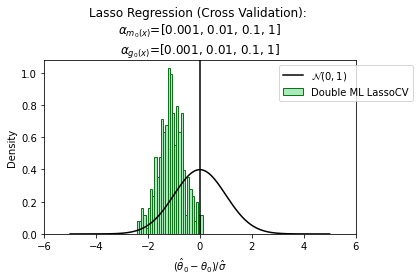

In [5]:
ml_l_cv_BCH = LassoCV(alphas=lasso_alpha_hyperparams_ml_l)
ml_m_cv_BCH = LassoCV(alphas=lasso_alpha_hyperparams_ml_m)

cv_thetas_BCH, cv_se_BCH, cv_plr_objects_BCH, \
cv_in_samples_mses_BCH, cv_out_of_samples_mses_BCH, \
cv_alphas_BCH = simulate_lasso_plr(ml_l=ml_l_cv_BCH, ml_m=ml_m_cv_BCH, n_folds=n_folds,
                                train_test_split=test_train_ratio, 
                                data=data_BCH14, score='partialling out')
plot_lasso_score(ml_l=ml_l_cv_BCH, ml_m=ml_m_cv_BCH, theta_scores=cv_thetas_BCH, se_scores=cv_se_BCH, alpha=alpha)

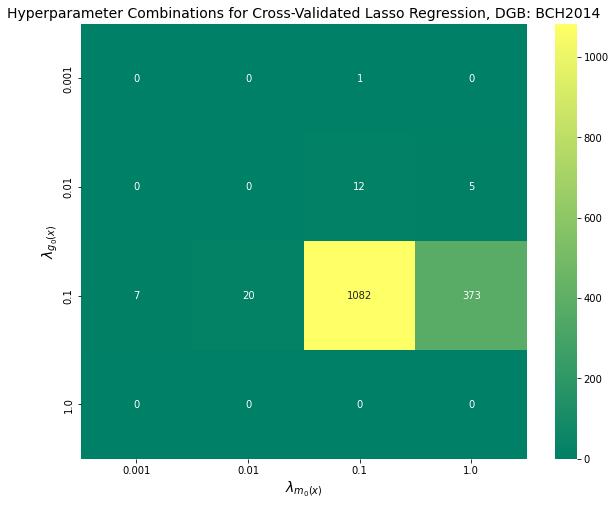

In [7]:
every_hyperparameter_combination = list(itertools.product(lasso_alpha_hyperparams_ml_l,
                                                        lasso_alpha_hyperparams_ml_m))

lasso_alphas_counts_BCH = {}

for comb in every_hyperparameter_combination:
    lasso_alphas_counts_BCH[comb] = 0

for occ in cv_alphas_BCH:
    lasso_alphas_counts_BCH[occ] += 1

counts_list_BCH = [(k[0], k[1], v) for k, v in lasso_alphas_counts_BCH.items()]
lasso_alphas_df_BCH = pd.DataFrame(counts_list_BCH, columns=['ml_l_alphas', 'ml_m_alphas', 'count'])
pivot_table_BCH = lasso_alphas_df_BCH.pivot(index='ml_l_alphas', columns='ml_m_alphas', values='count')

plt.figure(figsize=(2.5*len(lasso_alpha_hyperparams_ml_l), 2*len(lasso_alpha_hyperparams_ml_m)))
plt.title("Hyperparameter Combinations for Cross-Validated Lasso Regression, DGB: BCH2014", fontsize=14)
sns.heatmap(pivot_table_BCH, cmap='summer', annot=True, fmt=".0f")
plt.xlabel('$\\lambda_{m_{0}(x)}$', fontsize=14)
plt.ylabel('$\\lambda_{g_{0}(x)}$', fontsize=14)
plt.savefig("plots/cross_validated_lasso_hyperparameters_BCH2014.png", facecolor="white")
plt.show()

# 4. Delimited Hyperparameter Search Area

In [9]:
lasso_alpha_hyperparams_ml_m_delimited = list(np.arange(0.08, 0.12, 0.01))
lasso_alpha_hyperparams_ml_l_delimited = list(np.arange(0.08, 0.12, 0.01))

100%|██████████| 4/4 [02:47<00:00, 41.98s/it]


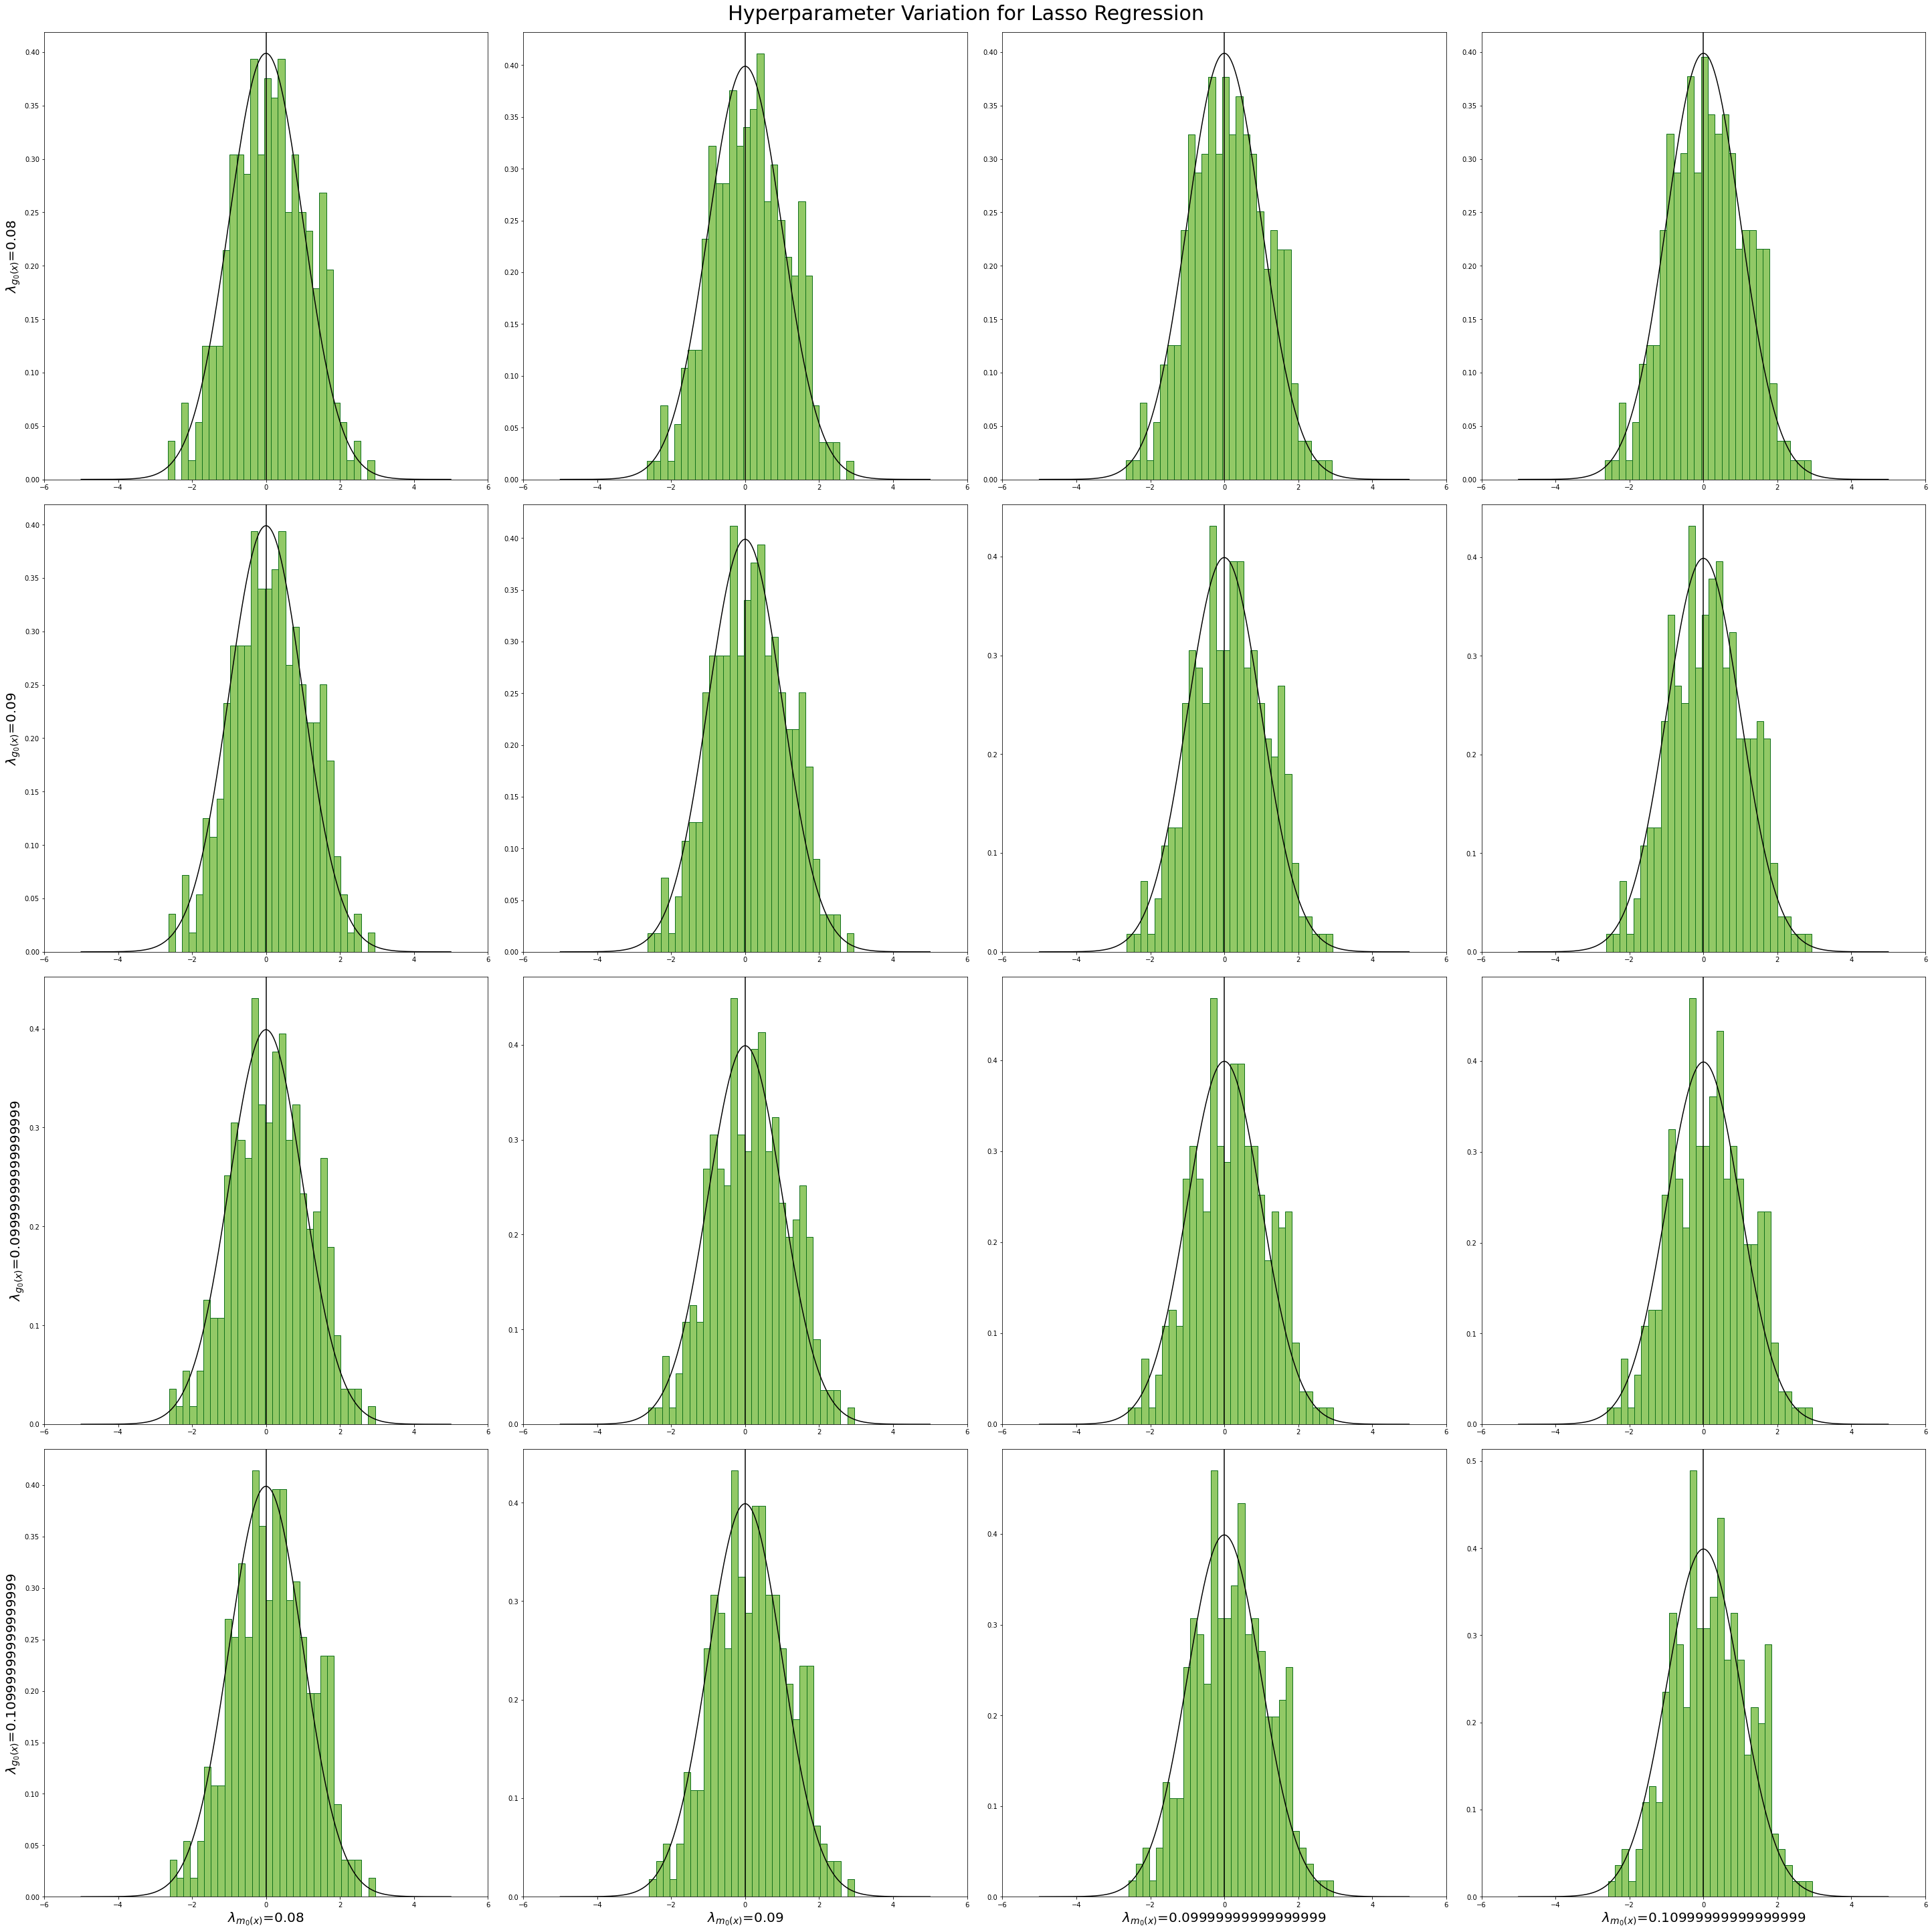

In [10]:
face_colors = sns.color_palette('summer_r')
edge_colors = sns.color_palette('dark')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

fig, axs = plt.subplots(len(lasso_alpha_hyperparams_ml_l_delimited), len(lasso_alpha_hyperparams_ml_m_delimited), 
                        figsize=(10*len(lasso_alpha_hyperparams_ml_l_delimited), 10*len(lasso_alpha_hyperparams_ml_m_delimited)), 
                        constrained_layout=True)

fig.suptitle("Hyperparameter Variation for Lasso Regression", fontsize=30)

for i_ml_m in tqdm(lasso_alpha_hyperparams_ml_m_delimited):
    for i_ml_l in lasso_alpha_hyperparams_ml_l_delimited:

        i_m = lasso_alpha_hyperparams_ml_m_delimited.index(i_ml_m)
        i_l = lasso_alpha_hyperparams_ml_l_delimited.index(i_ml_l)

        ml_l = Lasso(alpha=i_ml_l)
        ml_m = Lasso(alpha=i_ml_m)
        
        theta_scores_delimited, se_scores_delimited, plr_objects_delimited, \
        in_samples_mses_delimited, out_of_samples_mses_delimited, _ = simulate_lasso_plr(ml_l=ml_l, ml_m=ml_m, n_folds=n_folds,
                                                                                         train_test_split=test_train_ratio, 
                                                                                         data=data, score='partialling out')
        axs[i_l, i_m].hist((theta_scores_delimited - alpha)/se_scores_delimited,
                            color=face_colors[2], edgecolor = edge_colors[2],
                            density=True, bins=30, label='Double ML Lasso')
        axs[i_l, i_m].axvline(0., color='k')
        axs[i_l, i_m].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
        #axs[i_l, i_m].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        axs[len(lasso_alpha_hyperparams_ml_l_delimited)-1, i_m].set_xlabel('$\\lambda_{m_{0}(x)}$=' + f'{i_ml_m}', fontsize=20)
        axs[i_l, 0].set_ylabel('$\\lambda_{g_{0}(x)}$=' + f'{i_ml_l}', fontsize=20)
        axs[i_l, i_m].set_xlim([-6., 6.])

plt.savefig("plots/lasso_hyperparameter_variation_delimited.png", facecolor="white")

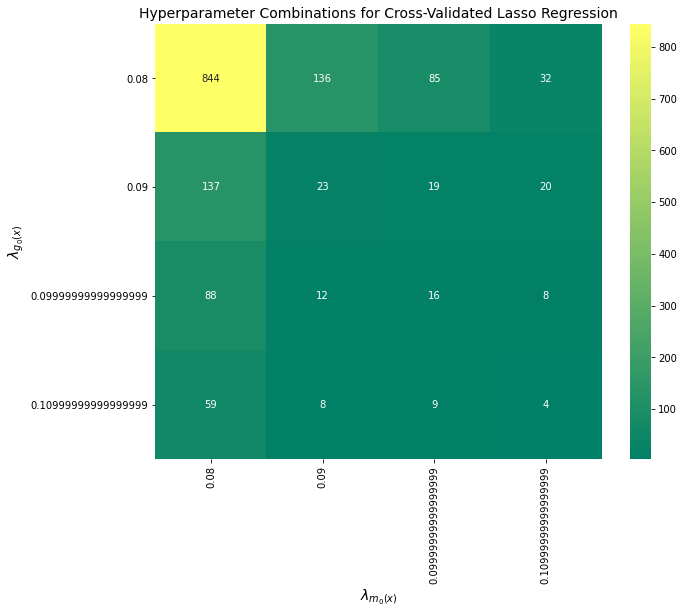

In [11]:
ml_l_cv_delimited = LassoCV(alphas=lasso_alpha_hyperparams_ml_l_delimited)
ml_m_cv_delimited = LassoCV(alphas=lasso_alpha_hyperparams_ml_m_delimited)

cv_thetas_delimited, cv_se_delimited, cv_plrobjects_delimited, cv_in_samples_mses_delimited, \
cv_out_of_samples_mses_delimited, cv_alphas_delimited = simulate_lasso_plr(ml_l=ml_l_cv_delimited, 
                                                                           ml_m=ml_m_cv_delimited, 
                                                                           n_folds=n_folds,
                                                                           train_test_split=test_train_ratio, 
                                                                           data=data, score='partialling out')

every_hyperparameter_combination = list(itertools.product(lasso_alpha_hyperparams_ml_l_delimited,
                                                        lasso_alpha_hyperparams_ml_m_delimited))

lasso_alphas_counts = {}

for comb in every_hyperparameter_combination:
    lasso_alphas_counts[comb] = 0

for occ in cv_alphas_delimited:
    lasso_alphas_counts[occ] += 1

counts_list = [(k[0], k[1], v) for k, v in lasso_alphas_counts.items()]
lasso_alphas_df = pd.DataFrame(counts_list, columns=['ml_l_alphas', 'ml_m_alphas', 'count'])
pivot_table = lasso_alphas_df.pivot(index='ml_l_alphas', columns='ml_m_alphas', values='count')

plt.figure(figsize=(2.5*len(lasso_alpha_hyperparams_ml_l_delimited), 
                    2*len(lasso_alpha_hyperparams_ml_m_delimited)))
plt.title("Hyperparameter Combinations for Cross-Validated Lasso Regression", fontsize=14)
sns.heatmap(pivot_table, cmap='summer', annot=True, fmt=".0f")
plt.xlabel('$\\lambda_{m_{0}(x)}$', fontsize=14)
plt.ylabel('$\\lambda_{g_{0}(x)}$', fontsize=14)
plt.savefig("plots/cross_validated_lasso_hyperparameters_delimited.png", facecolor="white")
plt.show()

# 5. BCH2014: n and p Variation

## 5.1 "Tall Data": Big n, Small p 

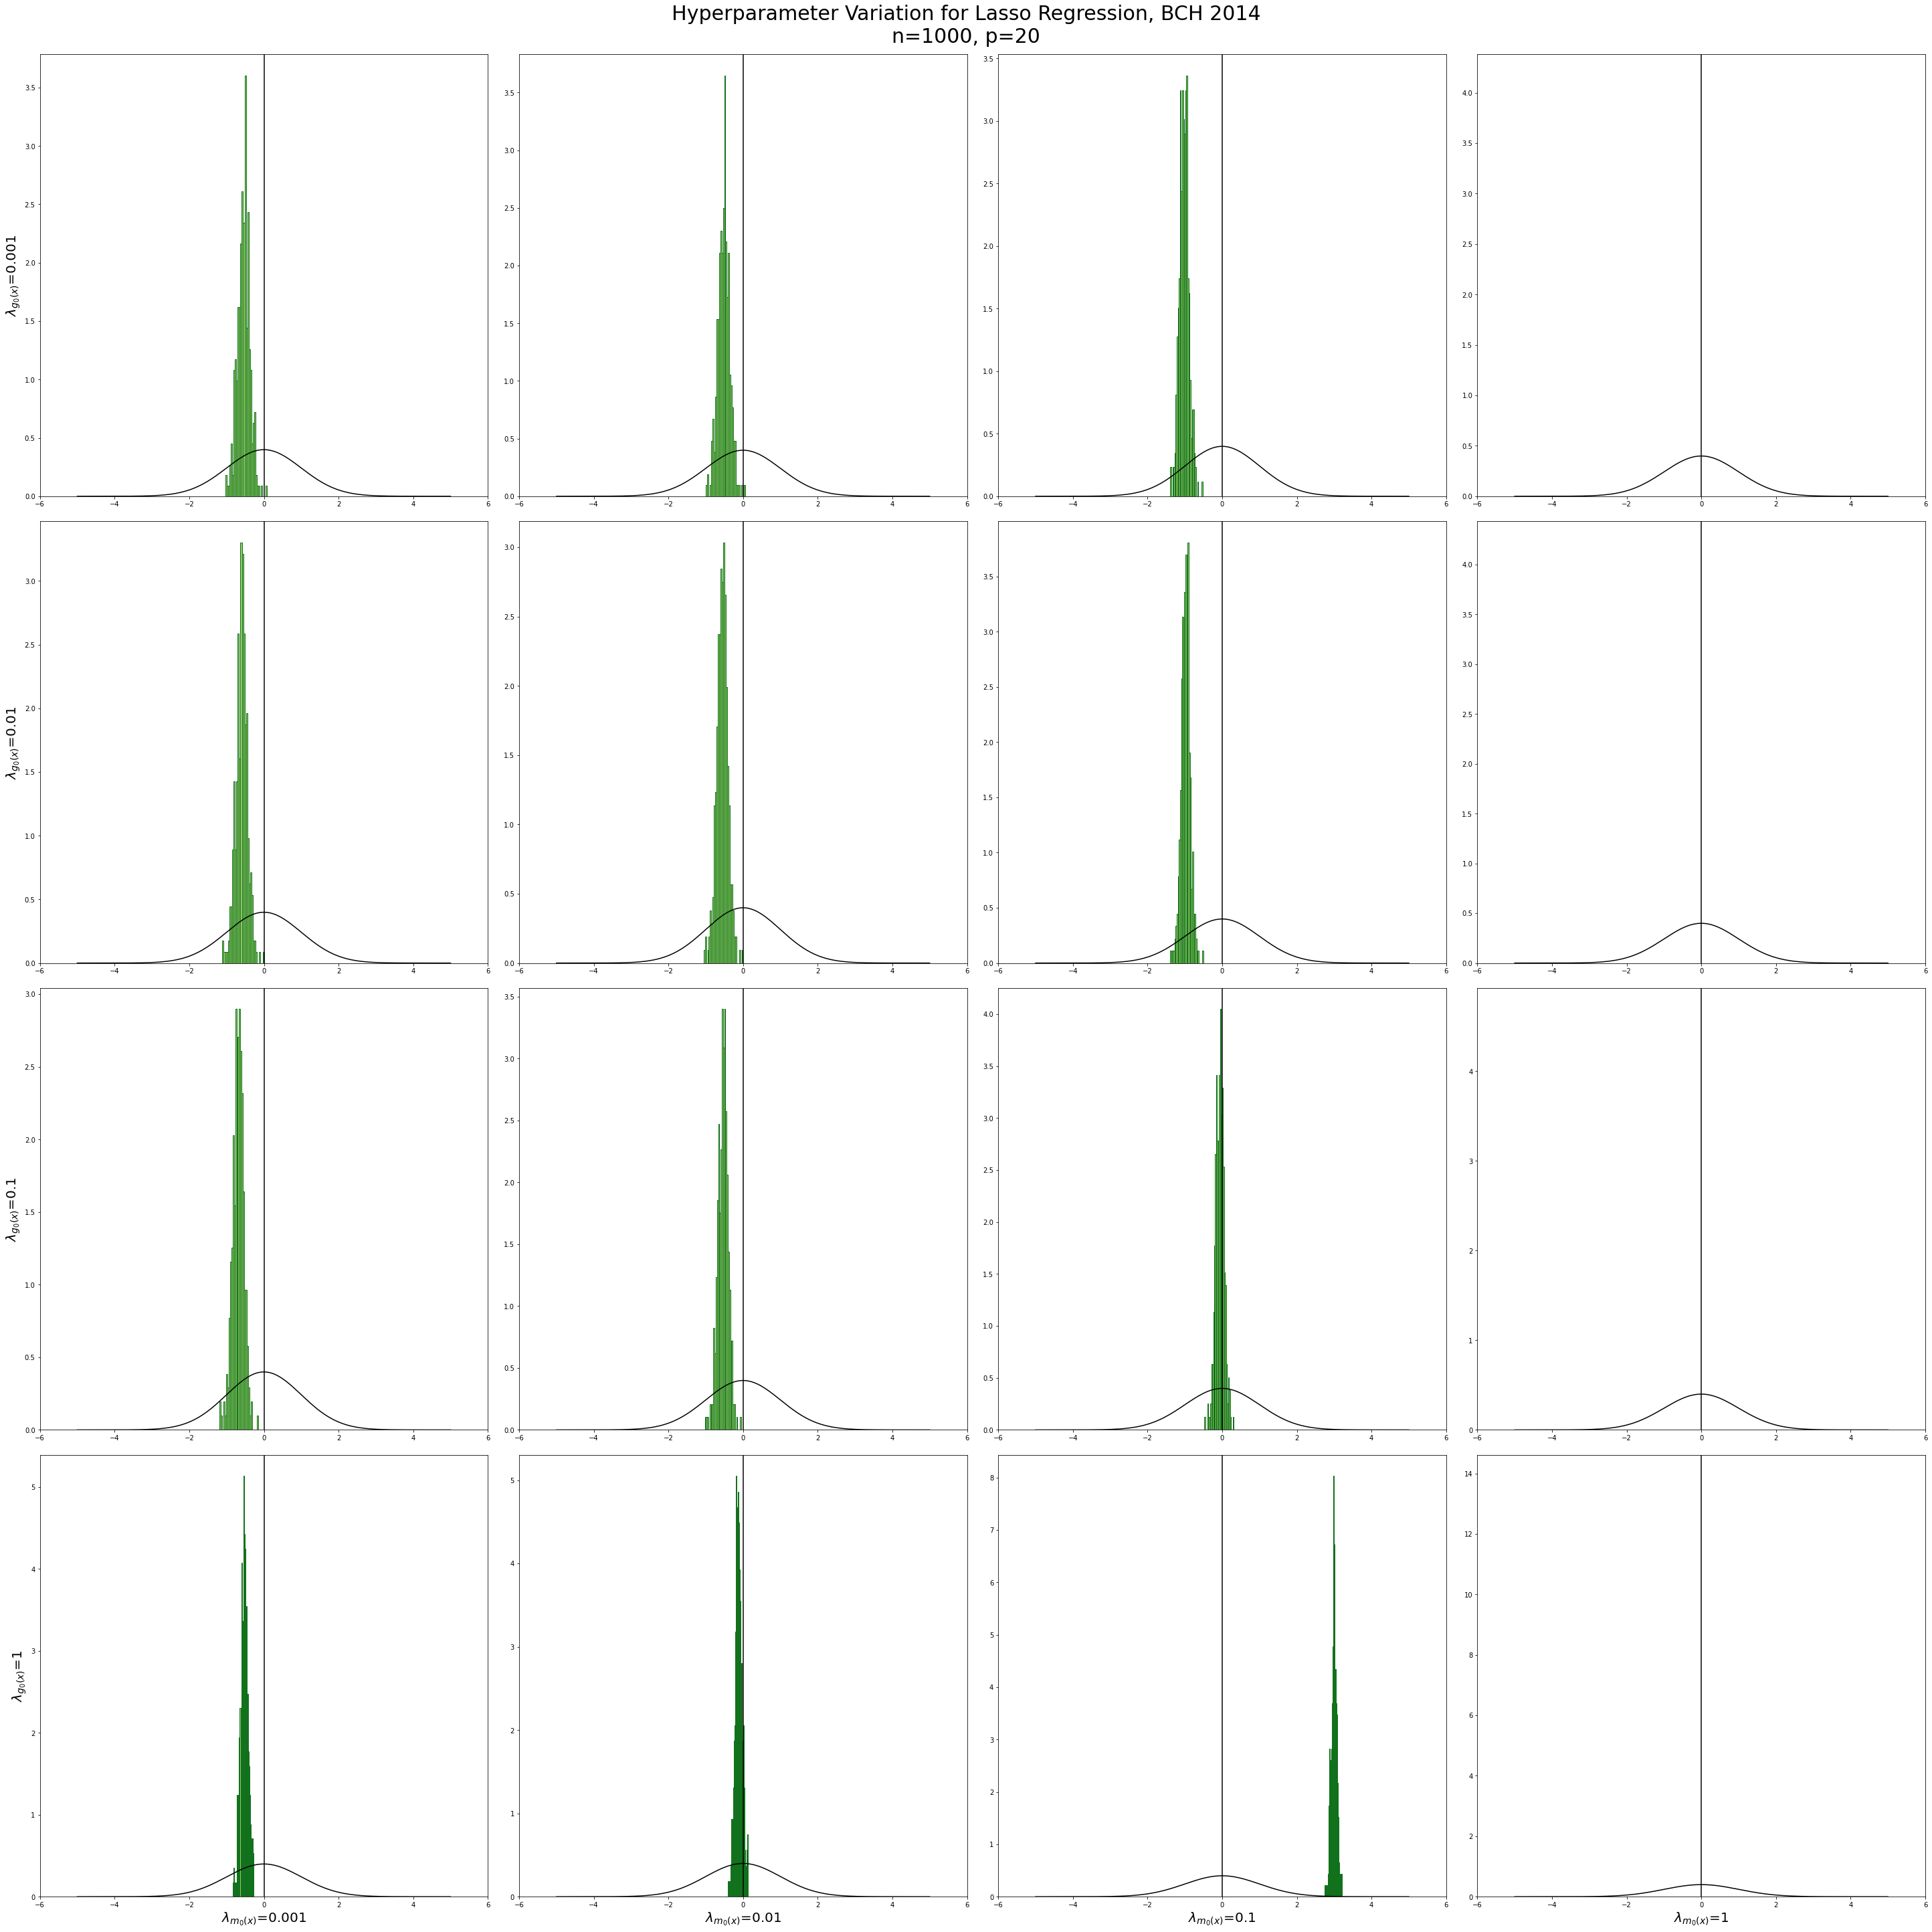

In [5]:
n_obs_tall = 1000
dim_x_tall = 20

data_BCH14_tall = make_BCH2014_data_list(n_rep=n_rep_BCH14, theta=theta_BCH14, n_obs=n_obs_tall, dim_x=dim_x_tall,
                                        rho=rho_BCH14, R2_d=R2_d_BCH14, R2_y=R2_y_BCH14, design=design_BCH14, random_seed=random_seed_BCH14)

face_colors = sns.color_palette('summer_r')
edge_colors = sns.color_palette('dark')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

mse_scores = []

fig, axs = plt.subplots(len(lasso_alpha_hyperparams_ml_l), len(lasso_alpha_hyperparams_ml_m), 
                        figsize=(10*len(lasso_alpha_hyperparams_ml_l), 10*len(lasso_alpha_hyperparams_ml_m)), 
                        constrained_layout=True)

fig.suptitle(f"Hyperparameter Variation for Lasso Regression, BCH 2014\nn={n_obs_tall}, p={dim_x_tall}", fontsize=30)

for i_ml_m in lasso_alpha_hyperparams_ml_m:
    for i_ml_l in lasso_alpha_hyperparams_ml_l:

        i_m = lasso_alpha_hyperparams_ml_m.index(i_ml_m)
        i_l = lasso_alpha_hyperparams_ml_l.index(i_ml_l)

        ml_l = Lasso(alpha=i_ml_l)
        ml_m = Lasso(alpha=i_ml_m)
        
        theta_scores, se_scores, plr_objects, in_sample_mses, \
        out_of_samples_mses, _ = simulate_lasso_plr(ml_l=ml_l, ml_m=ml_m, 
                                                    n_folds=n_folds, data=data_BCH14_tall,
                                                    train_test_split=test_train_ratio, 
                                                    score='partialling out')
        
        mse_entry = {
            "Hyperparameter_m": i_ml_m,
            "Hyperparameter_l": i_ml_l,
            "In_Sample_MSEs": in_sample_mses,
            "Out_Of_Sample_MSEs": out_of_samples_mses,
            "Train_Test_Split": test_train_ratio
        }

        mse_scores.append(mse_entry)

        axs[i_l, i_m].hist((theta_scores - theta_BCH14)/se_scores,
                            color=face_colors[2], edgecolor = edge_colors[2],
                            density=True, bins=30, label='Double ML Lasso')
        axs[i_l, i_m].axvline(0., color='k')
        axs[i_l, i_m].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
        #axs[i_l, i_m].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        axs[len(lasso_alpha_hyperparams_ml_l)-1, i_m].set_xlabel('$\\lambda_{m_{0}(x)}$=' + f'{i_ml_m}', fontsize=20)
        axs[i_l, 0].set_ylabel('$\\lambda_{g_{0}(x)}$=' + f'{i_ml_l}', fontsize=20)
        axs[i_l, i_m].set_xlim([-6., 6.])

plt.savefig("plots/lasso_hyperparameter_variation_BCH2014_tall_data.png", facecolor="white")

## 5.2 "Wide Data": Small n, Big p

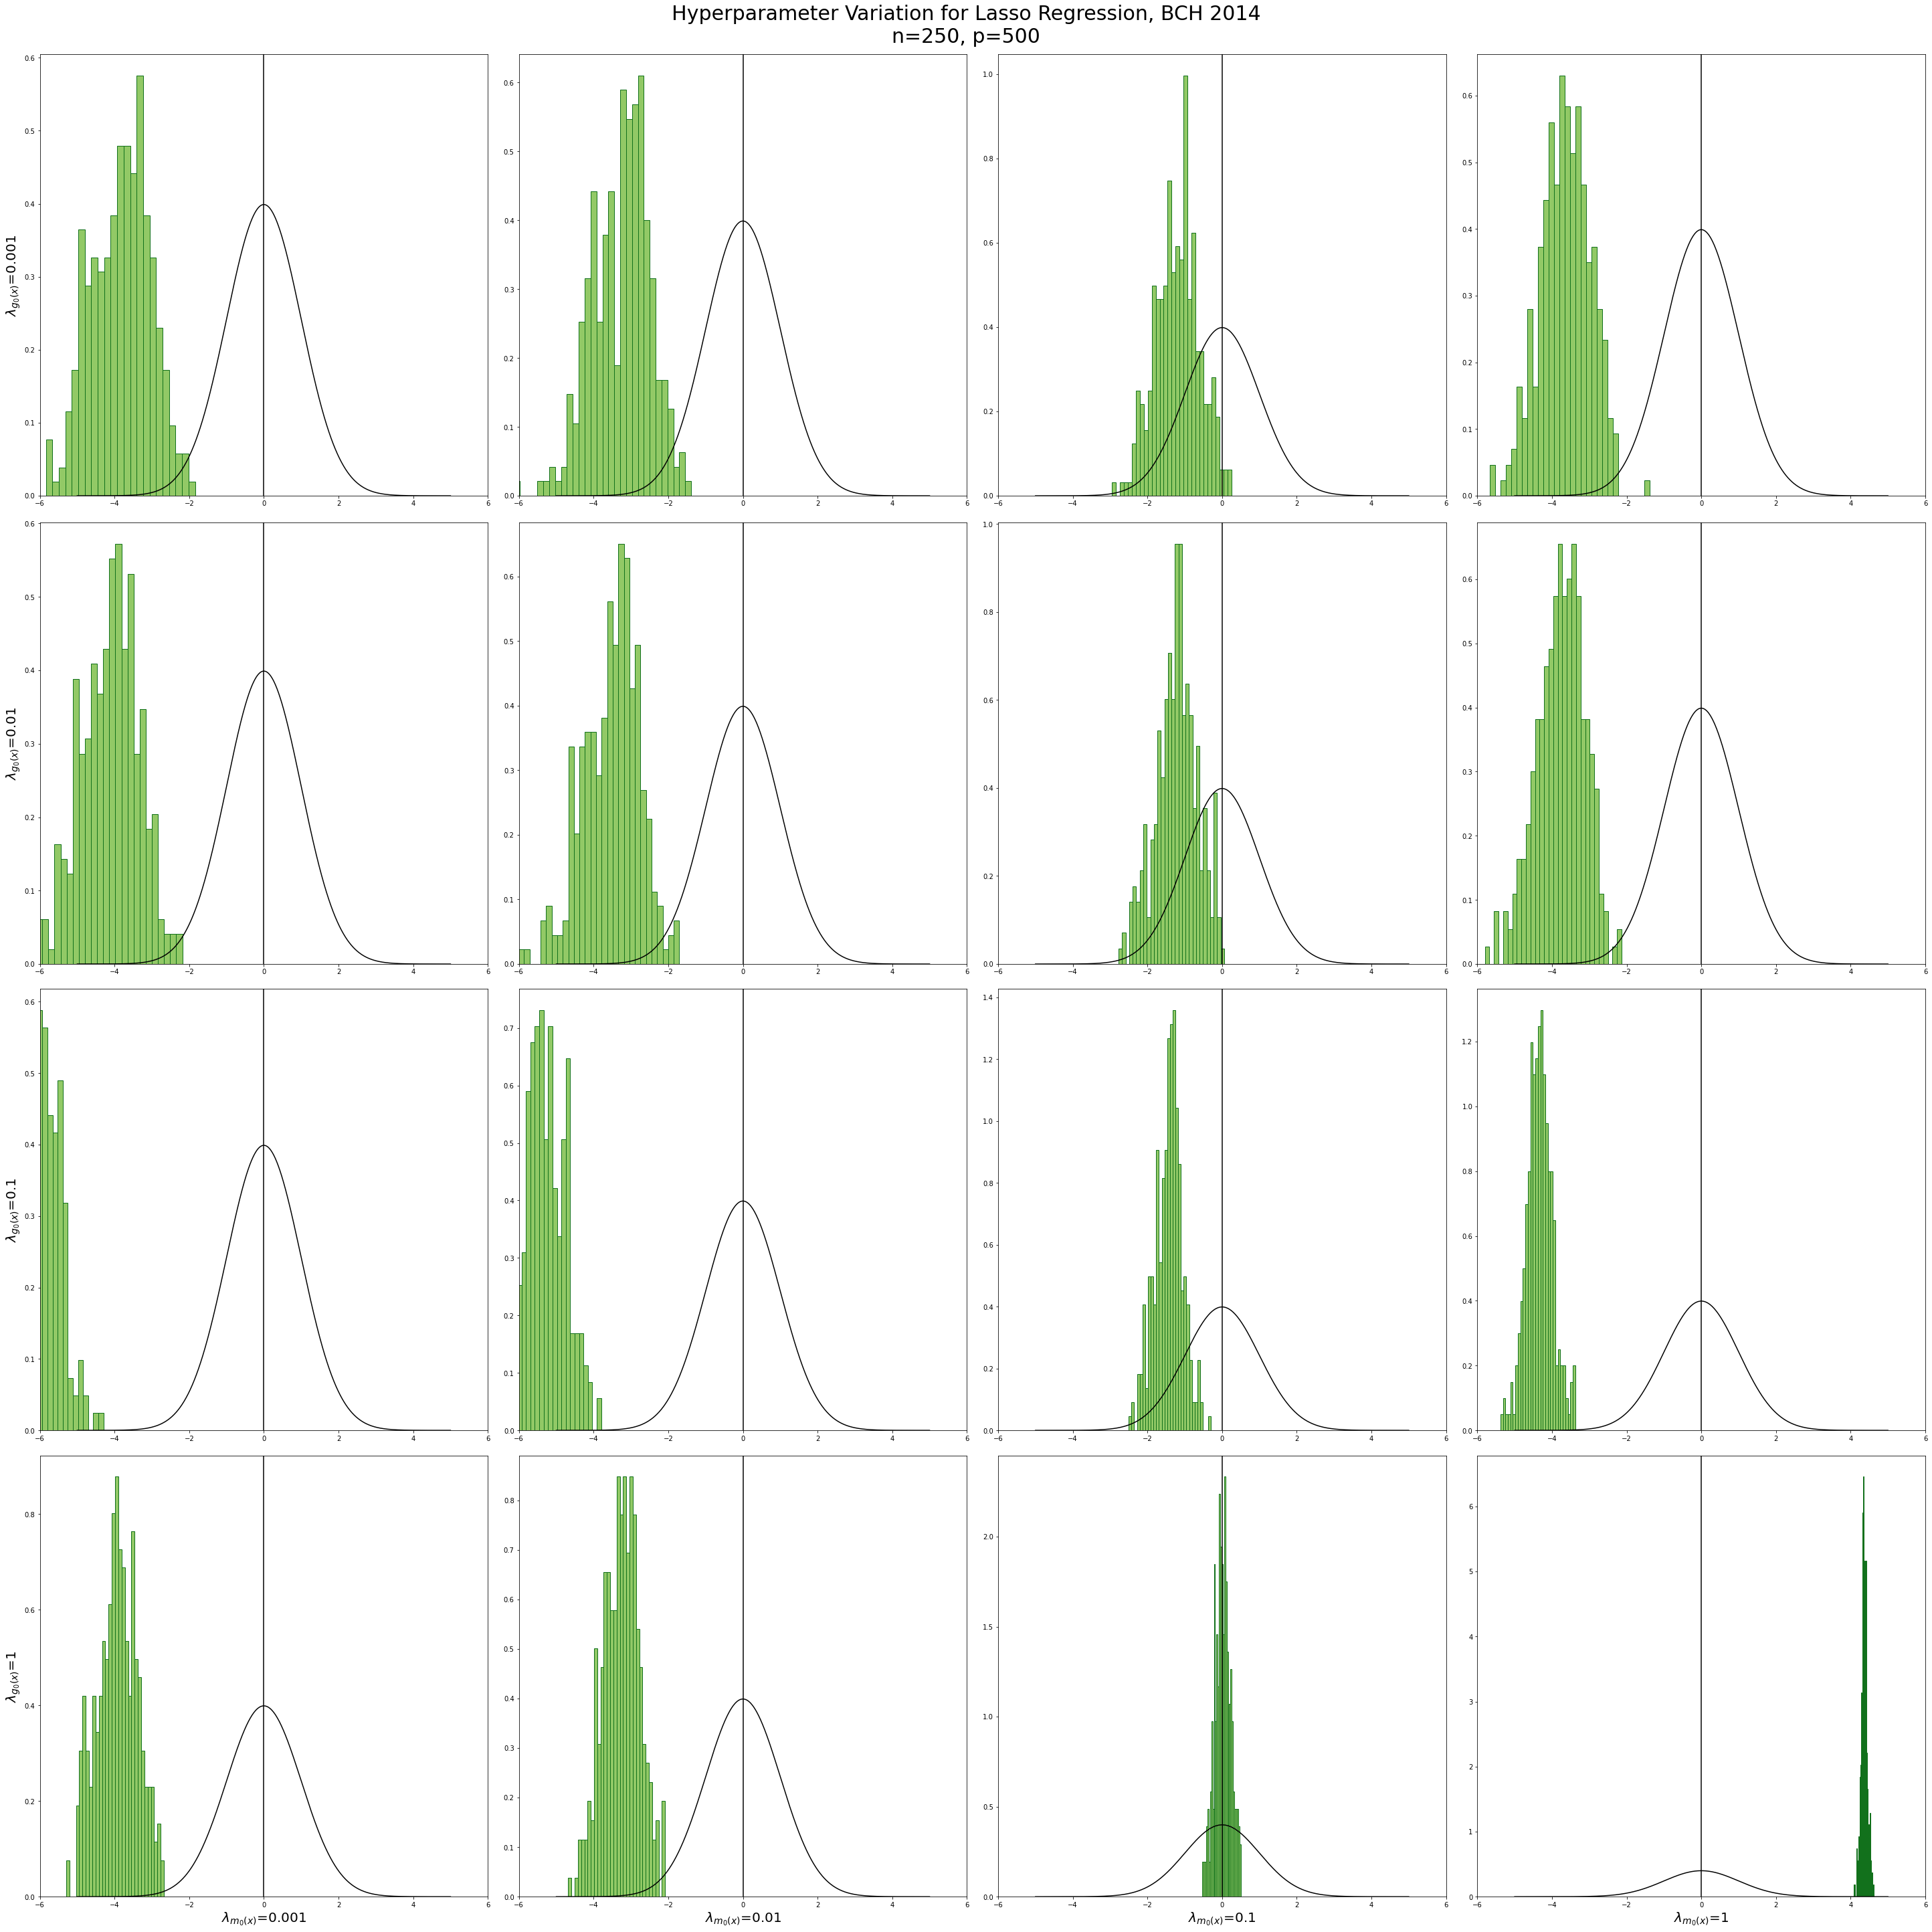

In [6]:
n_obs_wide = 250
dim_x_wide = 500

data_BCH14_wide = make_BCH2014_data_list(n_rep=n_rep_BCH14, theta=theta_BCH14, n_obs=n_obs_wide, dim_x=dim_x_wide,
                                        rho=rho_BCH14, R2_d=R2_d_BCH14, R2_y=R2_y_BCH14, design=design_BCH14, random_seed=random_seed_BCH14)

face_colors = sns.color_palette('summer_r')
edge_colors = sns.color_palette('dark')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

mse_scores = []

fig, axs = plt.subplots(len(lasso_alpha_hyperparams_ml_l), len(lasso_alpha_hyperparams_ml_m), 
                        figsize=(10*len(lasso_alpha_hyperparams_ml_l), 10*len(lasso_alpha_hyperparams_ml_m)), 
                        constrained_layout=True)

fig.suptitle(f"Hyperparameter Variation for Lasso Regression, BCH 2014\nn={n_obs_wide}, p={dim_x_wide}", fontsize=30)

for i_ml_m in lasso_alpha_hyperparams_ml_m:
    for i_ml_l in lasso_alpha_hyperparams_ml_l:

        i_m = lasso_alpha_hyperparams_ml_m.index(i_ml_m)
        i_l = lasso_alpha_hyperparams_ml_l.index(i_ml_l)

        ml_l = Lasso(alpha=i_ml_l)
        ml_m = Lasso(alpha=i_ml_m)
        
        theta_scores, se_scores, plr_objects, in_sample_mses, \
        out_of_samples_mses, _ = simulate_lasso_plr(ml_l=ml_l, ml_m=ml_m, 
                                                    n_folds=n_folds, data=data_BCH14_wide,
                                                    train_test_split=test_train_ratio, 
                                                    score='partialling out')
        
        mse_entry = {
            "Hyperparameter_m": i_ml_m,
            "Hyperparameter_l": i_ml_l,
            "In_Sample_MSEs": in_sample_mses,
            "Out_Of_Sample_MSEs": out_of_samples_mses,
            "Train_Test_Split": test_train_ratio
        }

        mse_scores.append(mse_entry)

        axs[i_l, i_m].hist((theta_scores - theta_BCH14)/se_scores,
                            color=face_colors[2], edgecolor = edge_colors[2],
                            density=True, bins=30, label='Double ML Lasso')
        axs[i_l, i_m].axvline(0., color='k')
        axs[i_l, i_m].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
        #axs[i_l, i_m].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        axs[len(lasso_alpha_hyperparams_ml_l)-1, i_m].set_xlabel('$\\lambda_{m_{0}(x)}$=' + f'{i_ml_m}', fontsize=20)
        axs[i_l, 0].set_ylabel('$\\lambda_{g_{0}(x)}$=' + f'{i_ml_l}', fontsize=20)
        axs[i_l, i_m].set_xlim([-6., 6.])

plt.savefig("plots/lasso_hyperparameter_variation_BCH2014_wide_data.png", facecolor="white")

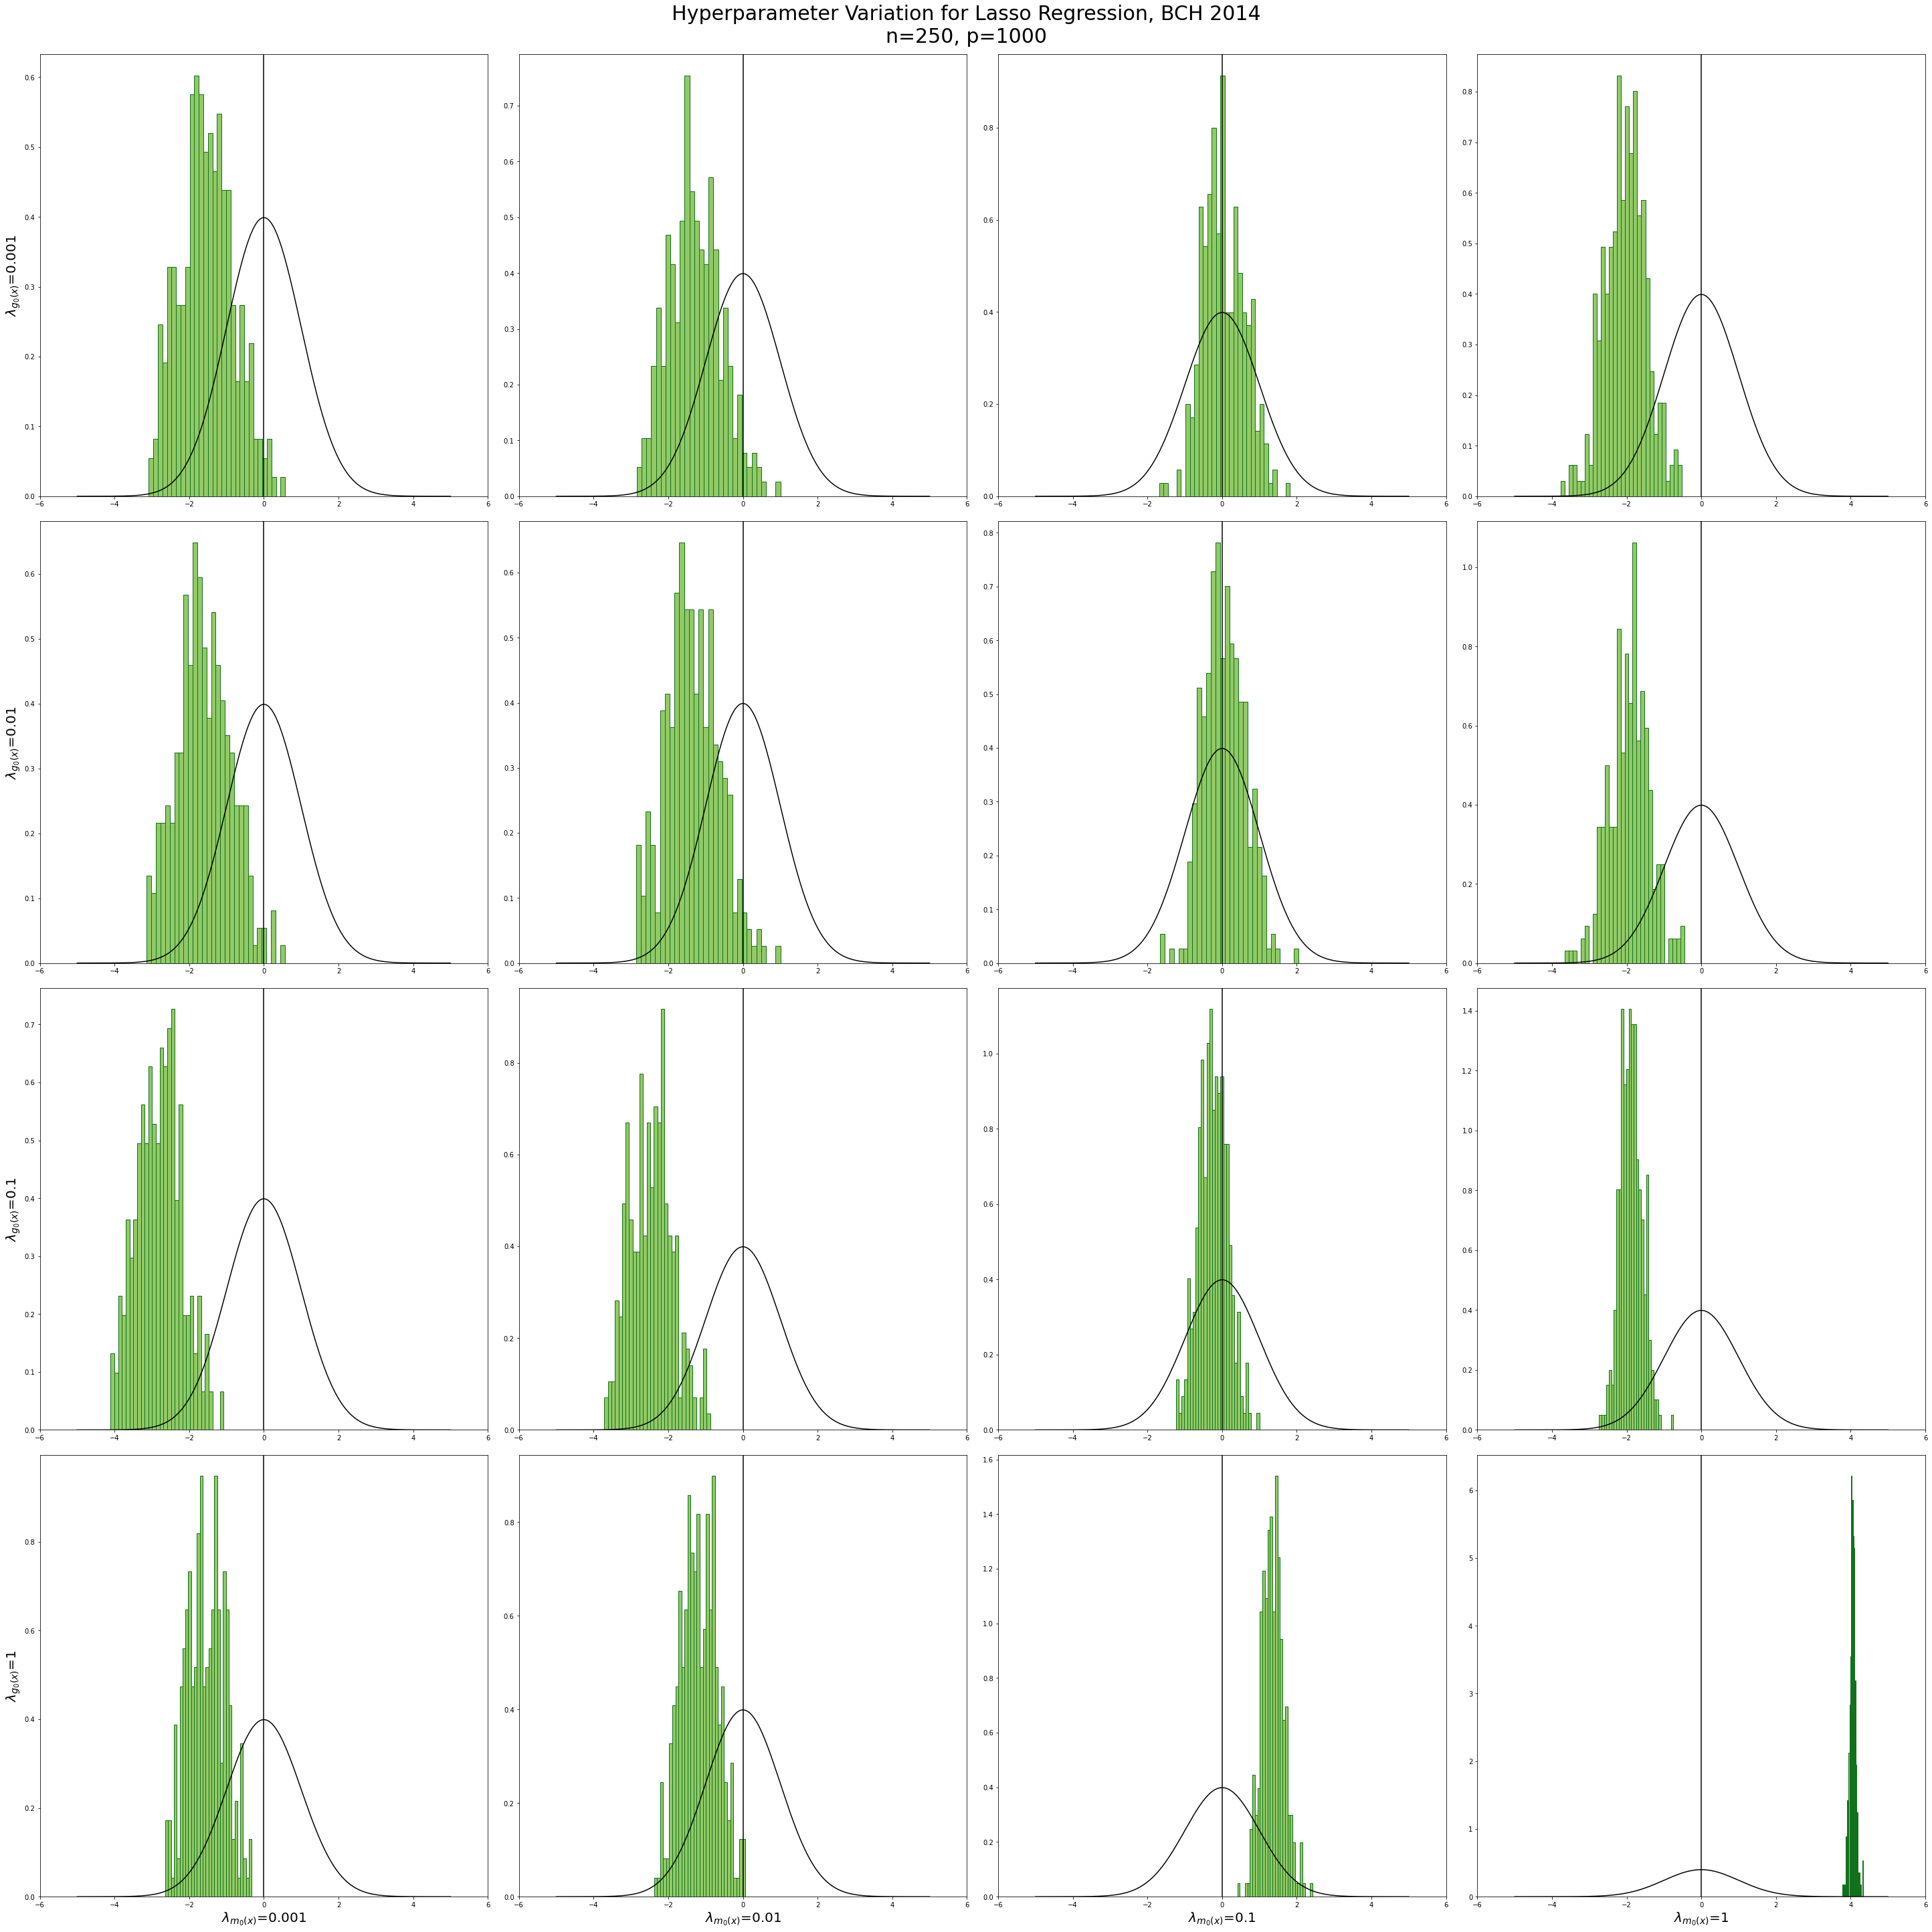

In [8]:
n_obs_wide = 250
dim_x_wide = 1000

data_BCH14_wide = make_BCH2014_data_list(n_rep=n_rep_BCH14, theta=theta_BCH14, n_obs=n_obs_wide, dim_x=dim_x_wide,
                                        rho=rho_BCH14, R2_d=R2_d_BCH14, R2_y=R2_y_BCH14, design=design_BCH14, random_seed=random_seed_BCH14)

face_colors = sns.color_palette('summer_r')
edge_colors = sns.color_palette('dark')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

mse_scores = []

fig, axs = plt.subplots(len(lasso_alpha_hyperparams_ml_l), len(lasso_alpha_hyperparams_ml_m), 
                        figsize=(10*len(lasso_alpha_hyperparams_ml_l), 10*len(lasso_alpha_hyperparams_ml_m)), 
                        constrained_layout=True)

fig.suptitle(f"Hyperparameter Variation for Lasso Regression, BCH 2014\nn={n_obs_wide}, p={dim_x_wide}", fontsize=30)

for i_ml_m in lasso_alpha_hyperparams_ml_m:
    for i_ml_l in lasso_alpha_hyperparams_ml_l:

        i_m = lasso_alpha_hyperparams_ml_m.index(i_ml_m)
        i_l = lasso_alpha_hyperparams_ml_l.index(i_ml_l)

        ml_l = Lasso(alpha=i_ml_l)
        ml_m = Lasso(alpha=i_ml_m)
        
        theta_scores, se_scores, plr_objects, in_sample_mses, \
        out_of_samples_mses, _ = simulate_lasso_plr(ml_l=ml_l, ml_m=ml_m, 
                                                    n_folds=n_folds, data=data_BCH14_wide,
                                                    train_test_split=test_train_ratio, 
                                                    score='partialling out')
        
        mse_entry = {
            "Hyperparameter_m": i_ml_m,
            "Hyperparameter_l": i_ml_l,
            "In_Sample_MSEs": in_sample_mses,
            "Out_Of_Sample_MSEs": out_of_samples_mses,
            "Train_Test_Split": test_train_ratio
        }

        mse_scores.append(mse_entry)

        axs[i_l, i_m].hist((theta_scores - theta_BCH14)/se_scores,
                            color=face_colors[2], edgecolor = edge_colors[2],
                            density=True, bins=30, label='Double ML Lasso')
        axs[i_l, i_m].axvline(0., color='k')
        axs[i_l, i_m].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
        #axs[i_l, i_m].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        axs[len(lasso_alpha_hyperparams_ml_l)-1, i_m].set_xlabel('$\\lambda_{m_{0}(x)}$=' + f'{i_ml_m}', fontsize=20)
        axs[i_l, 0].set_ylabel('$\\lambda_{g_{0}(x)}$=' + f'{i_ml_l}', fontsize=20)
        axs[i_l, i_m].set_xlim([-6., 6.])

plt.savefig("plots/lasso_hyperparameter_variation_BCH2014_wide_data_2.png", facecolor="white")

## 5.3 Something In Between

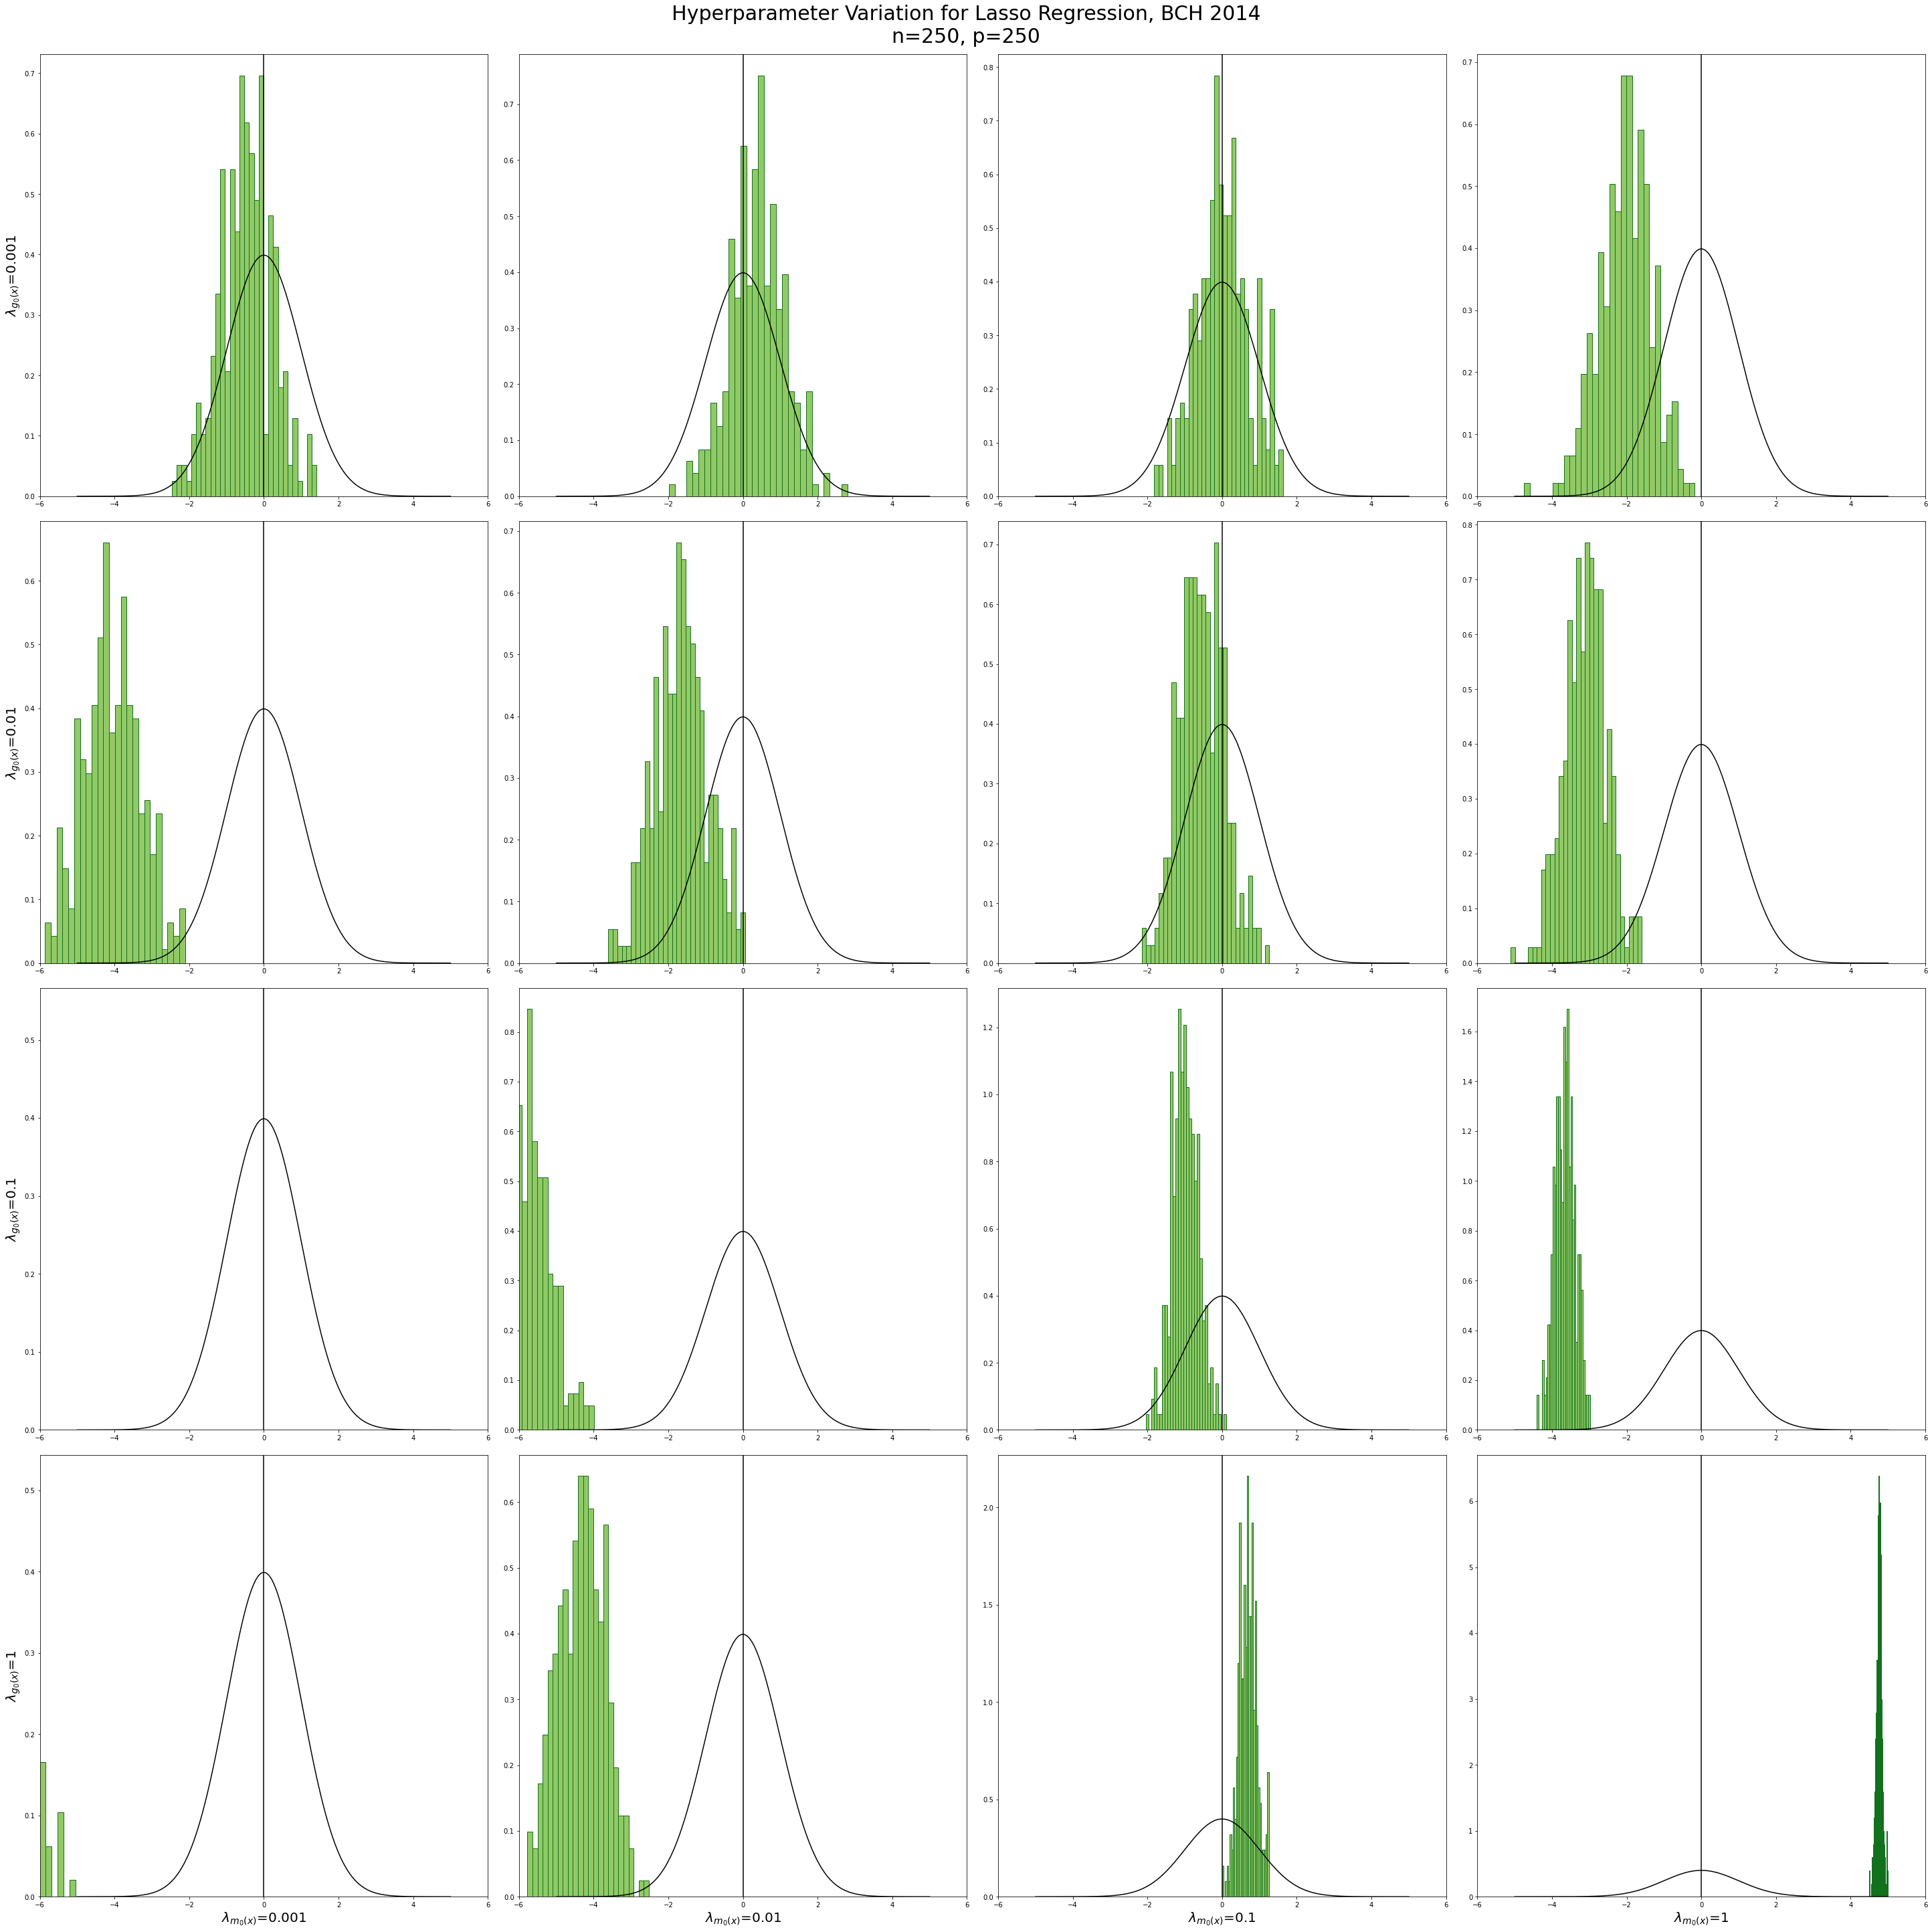

In [9]:
n_obs_quad = 250
dim_x_quad = 250

data_BCH14_quad = make_BCH2014_data_list(n_rep=n_rep_BCH14, theta=theta_BCH14, n_obs=n_obs_quad, dim_x=dim_x_quad,
                                        rho=rho_BCH14, R2_d=R2_d_BCH14, R2_y=R2_y_BCH14, design=design_BCH14, random_seed=random_seed_BCH14)

face_colors = sns.color_palette('summer_r')
edge_colors = sns.color_palette('dark')

xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)

mse_scores = []

fig, axs = plt.subplots(len(lasso_alpha_hyperparams_ml_l), len(lasso_alpha_hyperparams_ml_m), 
                        figsize=(10*len(lasso_alpha_hyperparams_ml_l), 10*len(lasso_alpha_hyperparams_ml_m)), 
                        constrained_layout=True)

fig.suptitle(f"Hyperparameter Variation for Lasso Regression, BCH 2014\nn={n_obs_quad}, p={dim_x_quad}", fontsize=30)

for i_ml_m in lasso_alpha_hyperparams_ml_m:
    for i_ml_l in lasso_alpha_hyperparams_ml_l:

        i_m = lasso_alpha_hyperparams_ml_m.index(i_ml_m)
        i_l = lasso_alpha_hyperparams_ml_l.index(i_ml_l)

        ml_l = Lasso(alpha=i_ml_l)
        ml_m = Lasso(alpha=i_ml_m)
        
        theta_scores, se_scores, plr_objects, in_sample_mses, \
        out_of_samples_mses, _ = simulate_lasso_plr(ml_l=ml_l, ml_m=ml_m, 
                                                    n_folds=n_folds, data=data_BCH14_quad,
                                                    train_test_split=test_train_ratio, 
                                                    score='partialling out')
        
        mse_entry = {
            "Hyperparameter_m": i_ml_m,
            "Hyperparameter_l": i_ml_l,
            "In_Sample_MSEs": in_sample_mses,
            "Out_Of_Sample_MSEs": out_of_samples_mses,
            "Train_Test_Split": test_train_ratio
        }

        mse_scores.append(mse_entry)

        axs[i_l, i_m].hist((theta_scores - theta_BCH14)/se_scores,
                            color=face_colors[2], edgecolor = edge_colors[2],
                            density=True, bins=30, label='Double ML Lasso')
        axs[i_l, i_m].axvline(0., color='k')
        axs[i_l, i_m].plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
        #axs[i_l, i_m].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        axs[len(lasso_alpha_hyperparams_ml_l)-1, i_m].set_xlabel('$\\lambda_{m_{0}(x)}$=' + f'{i_ml_m}', fontsize=20)
        axs[i_l, 0].set_ylabel('$\\lambda_{g_{0}(x)}$=' + f'{i_ml_l}', fontsize=20)
        axs[i_l, i_m].set_xlim([-6., 6.])

plt.savefig("plots/lasso_hyperparameter_variation_BCH2014_quad_data.png", facecolor="white")